## This notebook is for LRG specific results from SV3 LSS catalogs

In [1]:
import numpy as np
import fitsio
from matplotlib import pyplot as plt
import os
from scipy.special import erf
from astropy.table import Table,join,unique
from desitarget.sv3 import sv3_targetmask

In [2]:
ff = fitsio.read('/global/cfs/cdirs/desi/spectro/redux/everest/zcatalog/ztile-sv3-dark-cumulative.fits')
#select 1st LRG observations on good hardware
wlrg = ff['PRIORITY'] == 103200
wlrg &= ff['COADD_FIBERSTATUS'] == 0
ff = ff[wlrg]
#redshift success criteria from Rongpu
drz = (10**(3 - 3.5*ff['Z']))
mask_bad = (drz>30) & (ff['DELTACHI2']<30)
mask_bad |= (drz<30) & (ff['DELTACHI2']<drz)
mask_bad |= (ff['DELTACHI2']<10)
wz = ff['ZWARN'] == 0
wz &= ff['Z']<1.4
wz &= (~mask_bad)
print(len(ff[wz]))

136651


137517
135000


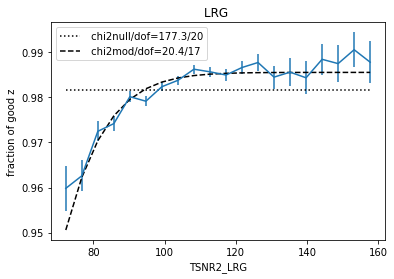

In [36]:
efac = 1#8.60
regl = ['N','S']
#for fr,reg in zip(frl,regl):
#wa = ff['LOCATION_ASSIGNED'] == 1
wa = ff['TSNR2_LRG'] != 1e20
wa &= ff['TSNR2_LRG'] > 70
wgh = wa & wz
print(len(ff[wa]))
#wgh &= ff['Z'] > zmin
#wgh &= ff['Z'] < zmax

print(len(ff[wgh]))
ffo = ff[wa]
ffz = ff[wgh]
rng = (70,160)
nb = 20
bs = (rng[1]-rng[0])/nb
a = np.histogram(ffz['TSNR2_LRG'],bins=nb,range=rng)
b = np.histogram(ffo['TSNR2_LRG'],bins=a[1])
#plt.clf()
fr = np.mean(a[0]/b[0])
dl = a[0]/b[0]#/fr
varl = dl*b[0]*(1.-dl) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
el = np.sqrt(varl)/b[0]#/fr
vs = a[1][:-1]+bs/2.
ol = np.ones(len(vs))#*0.74
em = erf((vs-13.2)/39.7)*.9855

chi2null = np.sum((dl-fr)**2./el**2.)
chi2m = np.sum((dl-em)**2./el**2.)
plt.errorbar(a[1][:-1]*efac+bs/2.,dl,el)#,label=' chi2null/dof='+str(round(chi2null,1))+'/'+str(nb))#,fmt='ko')


ol = np.ones(len(vs))*fr#*0.54
plt.plot(vs*efac,ol,'k:',label=' chi2null/dof='+str(round(chi2null,1))+'/'+str(nb))
plt.plot(vs*efac,em,'k--',label=' chi2mod/dof='+str(round(chi2m,1))+'/'+str(nb-3))             
plt.title('LRG ')
plt.xlabel('TSNR2_LRG')
plt.ylabel('fraction of good z')
plt.legend(loc='upper left')
plt.show()  

In [38]:
fibfluxz = ff['FIBERFLUX_Z']/10**(-0.4*ff['EBV']*1.211)#ff['MW_TRANSMISSION_Z']

137517
28559
27086
0.9484225638152597
28.64999870071904 2.7899999999999845


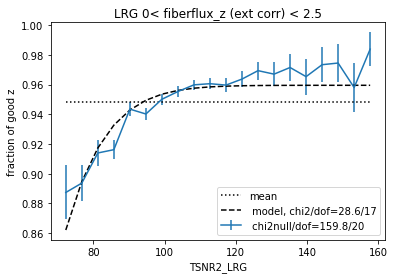

137517
27362
26783
0.9788392661355164
18.238924908066192 1.1100000000000008


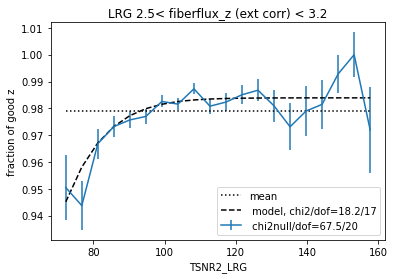

137517
27635
27371
0.9904468970508413
23.29807372956206 0.49000000000000027


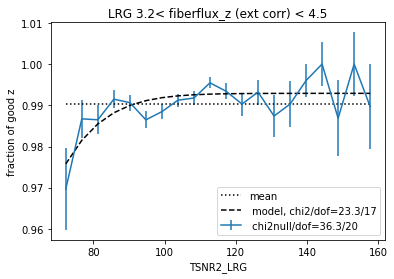

137517
27040
26902
0.994896449704142
26.763152104756575 0.23000000000000007


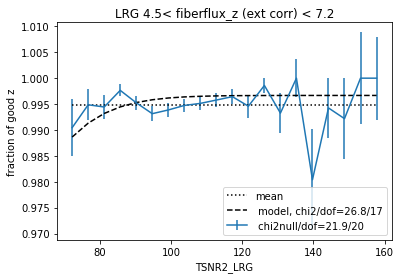

137517
26921
26858
0.9976598194717878
29.37175088079244 0.08


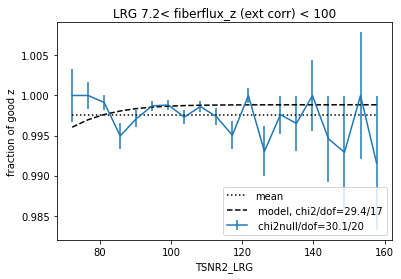

In [40]:
efac = 1#8.60
fs = [0,2.5,3.2,4.5,7.2]
deg =3
#for fr,reg in zip(frl,regl):
#for c in nl:
cs = []
mfs = []
for i in range(0,len(fs)):
    wa = ff['TSNR2_LRG'] != 1e20
    wa &= ff['TSNR2_LRG'] > 70
    
    print(len(ff[wa]))
    fm = fs[i]
    
    if i == len(fs)-1:
        fx = 100
    else:
        fx = fs[i+1]
    wa &= (fibfluxz < fx)
    wa &= (fibfluxz > fm)
    #wa &= ff['PHOTSYS'] == reg
    wgh = wa & wz
    print(len(ff[wa]))
    #wgh &= ff['Z'] > zmin
    #wgh &= ff['Z'] < zmax

    print(len(ff[wgh]))
    ffo = ff[wa]
    ffz = ff[wgh]
    print(len(ffz)/len(ffo))
    rng = (70,160)
    nb = 20
    bs = (rng[1]-rng[0])/nb
    a = np.histogram(ffz['TSNR2_LRG'],bins=nb,range=rng)
    b = np.histogram(ffo['TSNR2_LRG'],bins=a[1])
    #plt.clf()
    fr = np.sum(a[0])/np.sum(b[0])
    dl = a[0]/b[0]#/fr
    varl = dl*b[0]*(1.-dl) #variance for binomial distribution
    wv = varl == 0
    varl[wv] = 1
    el = np.sqrt(varl)/b[0]#/fr
    #el = np.sqrt(b[0]-a[0])/b[0]
    #(nt*nnwt/nt*(1.-nnwt/nt))**.5/nt

    vs = a[1][:-1]+bs/2.
    ol = np.ones(len(vs))#*0.74
    #deg = 4
    #coeff = np.polyfit(vs,dl,deg,w=1/el)
    #em = erf((vs)/50)*.975
    #em = np.zeros(len(vs))
    #for i in range(0,deg+1):
    #    em += coeff[i]*vs**(deg-i)
    #em = coeff[0]*vs**4+coeff[1]*vs**3+coeff[2]*vs**2.+coeff[3]*vs +coeff[4]
    efi = 0
    chi2min = 1000
    wv = vs > 180
    while efi < 4:
        emfi = 1. -(1.-em)*efi
        emfi[wv] =1.
        chi2i = np.sum((dl-emfi)**2./el**2.)
        if chi2i < chi2min:
            chi2min = chi2i
            ef = efi
        efi += 0.01
    print(chi2min,ef)
    cs.append(ef)
    mfs.append(np.mean(fibfluxz[wa]))
    emf = 1. -(1.-em)*ef
    
    emf[wv] =1.
    chi2m = np.sum((dl-emf)**2./el**2.)
    chi2null = np.sum((dl-fr)**2./el**2.)
    
    plt.errorbar(a[1][:-1]*efac+bs/2.,dl,el,label=' chi2null/dof='+str(round(chi2null,1))+'/'+str(nb))#,fmt='ko')


    ol = np.ones(len(vs))*fr#*0.54
    plt.plot(vs*efac,ol,'k:',label='mean')
    plt.plot(vs*efac,emf,'k--',label=' model, chi2/dof='+str(round(chi2m,1))+'/'+str(nb-deg))             
    plt.title('LRG '+ str(fm)+'< fiberflux_z (ext corr) < '+str(fx))
    #if c == 0:
    #    plt.title('LRG fiberflux_z (ext corr) < '+str(fx))
    #else:
    #    plt.title('LRG fiberflux_z (ext corr) > '+str(fx))
    plt.xlabel('TSNR2_LRG')
    plt.ylabel('fraction of good z')
    plt.legend(loc='lower right')
    plt.show()  

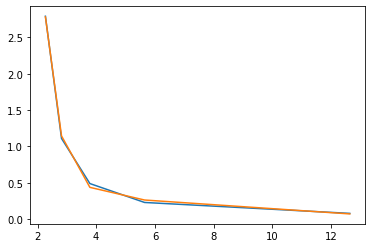

In [53]:
cs = np.array(cs)
mfs = np.array(mfs)
deg = 3
mod = np.polyfit(1/mfs,cs,deg)
modl = np.zeros(len(mfs))
for i in range(0,deg):
    modl += mod[i]*(1/mfs)**(deg-i)
modl += mod[deg]
plt.plot(mfs,cs)
plt.plot(mfs,modl)

In [54]:
mod

array([117.45867375, -60.90858826,  11.49155721,  -0.51355129])

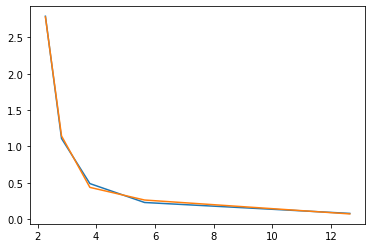

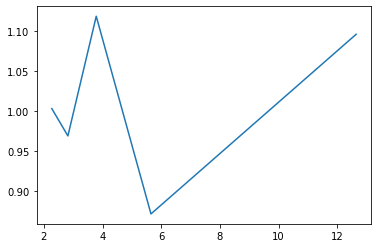

In [57]:
modr = [117.46,-60.91,11.49,-0.513]
modl = np.zeros(len(mfs))
for i in range(0,deg):
    modl += modr[i]*(1/mfs)**(deg-i)
modl += modr[deg]
plt.plot(mfs,cs)
plt.plot(mfs,modl)
plt.show()
plt.plot(mfs,cs/modl)
plt.show()

137517
28559
27086
0.9484225638152597
38.49529050092055 2.339999999999994


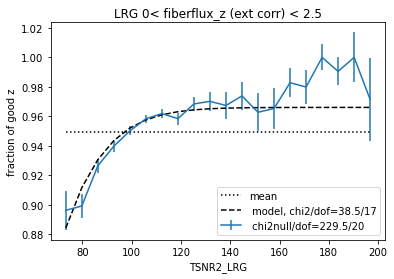

137517
27362
26783
0.9788392661355164
16.07886249847535 0.9500000000000006


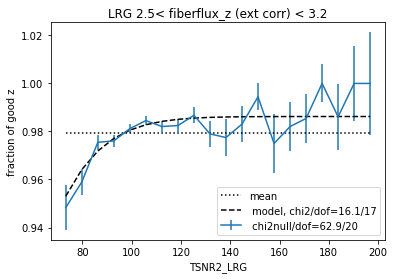

137517
27635
27371
0.9904468970508413
16.695465563409712 0.4200000000000002


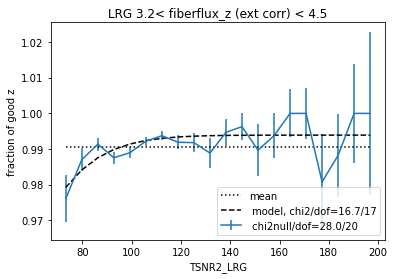

137517
27040
26902
0.994896449704142
25.910613508852474 0.19000000000000003


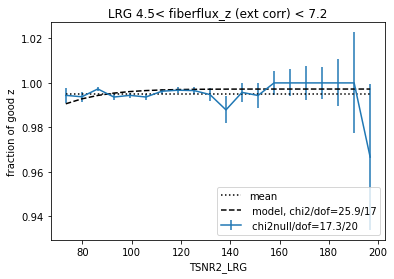

137517
26921
26858
0.9976598194717878
28.13120157030943 0.07


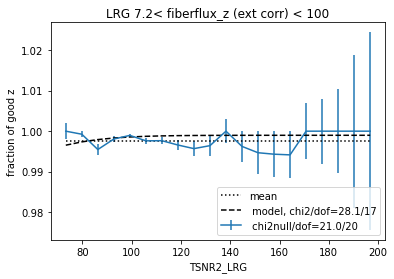

In [59]:
#check how different when increasing tsnr2 max
efac = 1#8.60
fs = [0,2.5,3.2,4.5,7.2]
deg =3
#for fr,reg in zip(frl,regl):
#for c in nl:
cs = []
mfs = []
for i in range(0,len(fs)):
    wa = ff['TSNR2_LRG'] != 1e20
    wa &= ff['TSNR2_LRG'] > 70
    
    print(len(ff[wa]))
    fm = fs[i]
    
    if i == len(fs)-1:
        fx = 100
    else:
        fx = fs[i+1]
    wa &= (fibfluxz < fx)
    wa &= (fibfluxz > fm)
    #wa &= ff['PHOTSYS'] == reg
    wgh = wa & wz
    print(len(ff[wa]))
    #wgh &= ff['Z'] > zmin
    #wgh &= ff['Z'] < zmax

    print(len(ff[wgh]))
    ffo = ff[wa]
    ffz = ff[wgh]
    print(len(ffz)/len(ffo))
    rng = (70,200)
    nb = 20
    bs = (rng[1]-rng[0])/nb
    a = np.histogram(ffz['TSNR2_LRG'],bins=nb,range=rng)
    b = np.histogram(ffo['TSNR2_LRG'],bins=a[1])
    #plt.clf()
    fr = np.sum(a[0])/np.sum(b[0])
    dl = a[0]/b[0]#/fr
    varl = dl*b[0]*(1.-dl) #variance for binomial distribution
    wv = varl == 0
    varl[wv] = 1
    el = np.sqrt(varl)/b[0]#/fr
    #el = np.sqrt(b[0]-a[0])/b[0]
    #(nt*nnwt/nt*(1.-nnwt/nt))**.5/nt

    vs = a[1][:-1]+bs/2.
    ol = np.ones(len(vs))#*0.74
    #deg = 4
    #coeff = np.polyfit(vs,dl,deg,w=1/el)
    #em = erf((vs)/50)*.975
    #em = np.zeros(len(vs))
    #for i in range(0,deg+1):
    #    em += coeff[i]*vs**(deg-i)
    #em = coeff[0]*vs**4+coeff[1]*vs**3+coeff[2]*vs**2.+coeff[3]*vs +coeff[4]
    efi = 0
    chi2min = 1000
    wv = vs > 200
    while efi < 4:
        emfi = 1. -(1.-em)*efi
        emfi[wv] =1.
        chi2i = np.sum((dl-emfi)**2./el**2.)
        if chi2i < chi2min:
            chi2min = chi2i
            ef = efi
        efi += 0.01
    print(chi2min,ef)
    cs.append(ef)
    mfs.append(np.mean(fibfluxz[wa]))
    emf = 1. -(1.-em)*ef
    
    emf[wv] =1.
    chi2m = np.sum((dl-emf)**2./el**2.)
    chi2null = np.sum((dl-fr)**2./el**2.)
    
    plt.errorbar(a[1][:-1]*efac+bs/2.,dl,el,label=' chi2null/dof='+str(round(chi2null,1))+'/'+str(nb))#,fmt='ko')


    ol = np.ones(len(vs))*fr#*0.54
    plt.plot(vs*efac,ol,'k:',label='mean')
    plt.plot(vs*efac,emf,'k--',label=' model, chi2/dof='+str(round(chi2m,1))+'/'+str(nb-deg))             
    plt.title('LRG '+ str(fm)+'< fiberflux_z (ext corr) < '+str(fx))
    #if c == 0:
    #    plt.title('LRG fiberflux_z (ext corr) < '+str(fx))
    #else:
    #    plt.title('LRG fiberflux_z (ext corr) > '+str(fx))
    plt.xlabel('TSNR2_LRG')
    plt.ylabel('fraction of good z')
    plt.legend(loc='lower right')
    plt.show()  

In [67]:
ff = fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/everest/LSScats/test/LRG_full.dat.fits')
print(len(ff))
fc = fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/everest/LSScats/test/LRG_clustering.dat.fits')
print(len(fc))
#fcm = fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/everest/LSScats/test/LRGAlltiles_main_clustering.dat.fits')
#print(len(fcm))
#print(len(fc)/len(fcm))

136691
128592


In [68]:
tsnrcut = 80
wlrg = ff['COADD_FIBERSTATUS'] == 0
ffz = ff[wlrg]
print(len(ffz))
#redshift success criteria from Rongpu
drz = (10**(3 - 3.5*ffz['Z']))
mask_bad = (drz>30) & (ffz['DELTACHI2']<30)
mask_bad |= (drz<30) & (ffz['DELTACHI2']<drz)
mask_bad |= (ffz['DELTACHI2']<10)
wz = ffz['ZWARN'] == 0
wz &= ffz['Z']<1.4
wz &= (~mask_bad)
wz &= ffz['TSNR2_ELG'] > tsnrcut
print(len(ffz[wz]),len(fc))

130979
128592 128592


In [70]:
sum(fc['WEIGHT_ZFAIL'])

131016.21836799383

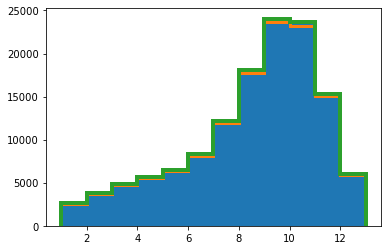

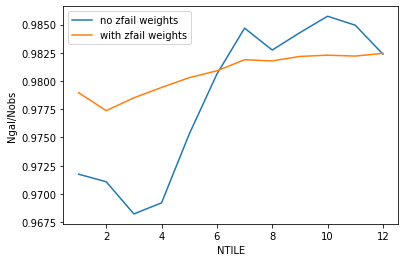

In [74]:
a = plt.hist(ffz['NTILE'],bins=12)
b = plt.hist(fc['NTILE'],bins=12,histtype='step',lw=3)
c = plt.hist(fc['NTILE'],bins=12,weights=fc['WEIGHT_ZFAIL'],histtype='step',lw=4)
plt.show()
plt.plot(a[1][:-1],b[0]/a[0],label='no zfail weights')
plt.plot(a[1][:-1],b[0]/c[0],label='with zfail weights')
plt.xlabel('NTILE')
plt.ylabel('Ngal/Nobs')
plt.legend()
plt.show()

In [12]:
wz = ff['COADD_FIBERSTATUS'] == 0
print(np.sum(ff['PROB_OBS']))
print(len(ff[wz]),len(ff[wz])/np.sum(ff['PROB_OBS']))
      

129774.515625
130979 1.009281362902409


In [6]:
fp = fitsio.read(os.environ['CSCRATCH']+'/pip/parent.fits')
print(len(fp))

86550


In [4]:
ffr = fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/LSScats/test/LRGAlltiles_0_full.ran.fits')

In [156]:
ff.dtype.names

('RA',
 'DEC',
 'TARGETID',
 'SV3_DESI_TARGET',
 'SV3_BGS_TARGET',
 'SV3_MWS_TARGET',
 'SUBPRIORITY',
 'PRIORITY_INIT',
 'TARGET_STATE',
 'TIMESTAMP',
 'ZWARN_MTL',
 'FIBER',
 'LOCATION',
 'TILEID',
 'TILELOCID',
 'CHI2',
 'COEFF',
 'Z',
 'ZERR',
 'ZWARN',
 'NPIXELS',
 'SPECTYPE',
 'SUBTYPE',
 'NCOEFF',
 'DELTACHI2',
 'NUMEXP',
 'NUMTILE',
 'FIBERSTATUS',
 'OBJTYPE',
 'FIBERASSIGN_X',
 'FIBERASSIGN_Y',
 'PRIORITY',
 'DELTA_X',
 'DELTA_Y',
 'EXPTIME',
 'PSF_TO_FIBER_SPECFLUX',
 'INTEG_COADD_FLUX_B',
 'MEDIAN_COADD_FLUX_B',
 'MEDIAN_COADD_SNR_B',
 'INTEG_COADD_FLUX_R',
 'MEDIAN_COADD_FLUX_R',
 'MEDIAN_COADD_SNR_R',
 'INTEG_COADD_FLUX_Z',
 'MEDIAN_COADD_FLUX_Z',
 'MEDIAN_COADD_SNR_Z',
 'TSNR2_ELG_B',
 'TSNR2_LYA_B',
 'TSNR2_BGS_B',
 'TSNR2_QSO_B',
 'TSNR2_LRG_B',
 'TSNR2_ELG_R',
 'TSNR2_LYA_R',
 'TSNR2_BGS_R',
 'TSNR2_QSO_R',
 'TSNR2_LRG_R',
 'TSNR2_ELG_Z',
 'TSNR2_LYA_Z',
 'TSNR2_BGS_Z',
 'TSNR2_QSO_Z',
 'TSNR2_LRG_Z',
 'TSNR2_ELG',
 'TSNR2_LYA',
 'TSNR2_BGS',
 'TSNR2_QSO',
 'TSNR2_LRG',

(array([2.3728e+04, 3.6888e+04, 2.8001e+04, 1.7710e+04, 1.7111e+04,
        1.0538e+04, 1.8640e+03, 6.0900e+02, 1.9900e+02, 9.0000e+00]),
 array([0.00298897, 0.01121669, 0.0194444 , 0.02767211, 0.03589982,
        0.04412753, 0.05235524, 0.06058295, 0.06881066, 0.07703838,
        0.08526609], dtype=float32),
 <a list of 10 Patch objects>)

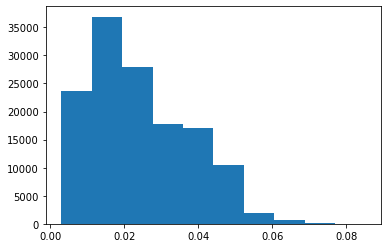

In [6]:
plt.hist(ff['EBV'])

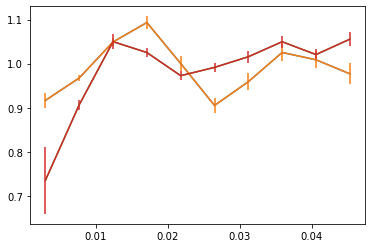

In [15]:
ps = ['N','S']
for p in ps:
    sel = ff['PHOTSYS'] == p
    selr = ffr['PHOTSYS'] == p
    wz = ff['ZWARN'] == 0
    wz &= ff['Z'] > 0.4
    wz &= ff['Z'] < 1.1
    a,bins = np.histogram(ff[sel&wz]['EBV'],weights=ff[sel&wz]['WEIGHT_ZFAIL']/ff[sel&wz]['FRACZ_TILELOCID'],range=(0.003,0.05))
    b,t = np.histogram(ffr[selr]['EBV'],bins=bins)
    plt.plot(bins[:-1],a/b*sum(b)/sum(a))
    plt.errorbar(bins[:-1],a/b*sum(b)/sum(a),np.sqrt(a)/b*sum(b)/sum(a))
    

total number of unique reachable LRG targets is 135708
total number of unique observed LRG targets is 130272
total number of unique LRG targets with good redshifts is 128825
targeting completeness is 0.9599434079052083
redshift success rate is 0.9888924711373127


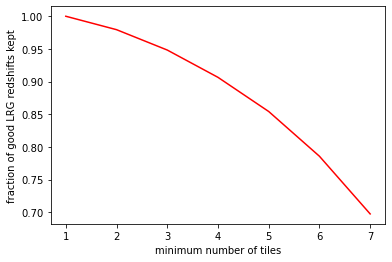

In [46]:
print('total number of unique reachable LRG targets is '+str(len(ff)))
wo = ff['LOCATION_ASSIGNED'] == 1
print('total number of unique observed LRG targets is '+str(len(ff[wo])))
wz = ff['ZWARN'] == 0
print('total number of unique LRG targets with good redshifts is '+str(len(ff[wz])))
print('targeting completeness is '+str(len(ff[wo])/len(ff)))
print('redshift success rate is '+str(len(ff[wz])/len(ff[wo])))
ngl = [len(ff[wz])]
ntm = [1]
for nt in range(1,7):
    wt = ff['NTILE'] > nt
    ntm.append(nt+1)
    ngl.append(len(ff[wz&wt]))
plt.plot(ntm,np.array(ngl)/len(ff[wz]),'r-')
plt.xlabel('minimum number of tiles')
plt.ylabel('fraction of good LRG redshifts kept')
plt.show()

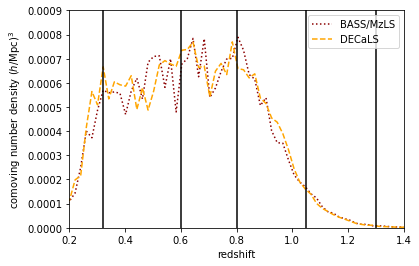

In [2]:
#plot n(z)
nz = np.loadtxt('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/LSScats/test/LRG_N_nz.dat').transpose()
plt.plot(nz[0],nz[3],':',color='darkred',label='BASS/MzLS')
nz = np.loadtxt('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/LSScats/test/LRG_S_nz.dat').transpose()
plt.plot(nz[0],nz[3],'--',color='orange',label='DECaLS')
plt.legend()
plt.xlim(0.2,1.4)
plt.ylim(0,0.0009)
xl = [0.32,0.32]
yl = [0,0.001]
plt.plot(xl,yl,'k-')
xl = [0.6,0.6]
yl = [0,0.001]
plt.plot(xl,yl,'k-')
xl = [0.8,0.8]
yl = [0,0.001]
plt.plot(xl,yl,'k-')
xl = [1.05,1.05]
yl = [0,0.001]
plt.plot(xl,yl,'k-')
xl = [1.3,1.3]
yl = [0,0.001]
plt.plot(xl,yl,'k-')
xl = [1.6,1.6]
yl = [0,0.001]
plt.plot(xl,yl,'k-')
plt.xlabel('redshift')
plt.ylabel(r'comoving number density ($h$/Mpc)$^3$')
plt.show()

In [34]:
wz = nz[0] > 0.32
wz &= nz[0] < 0.6
n = sum(nz[-2][wz])/sum(nz[-1][wz])
print(n)

0.000609514309512854


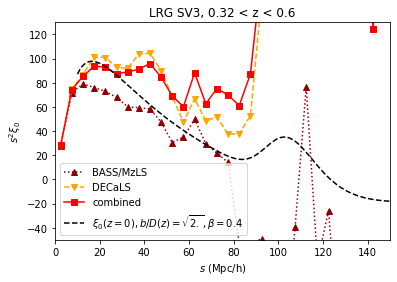

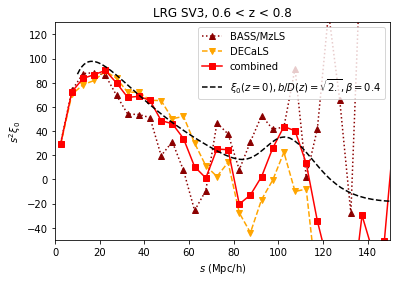

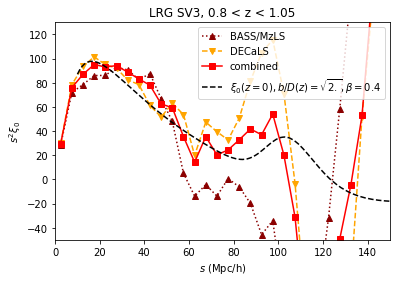

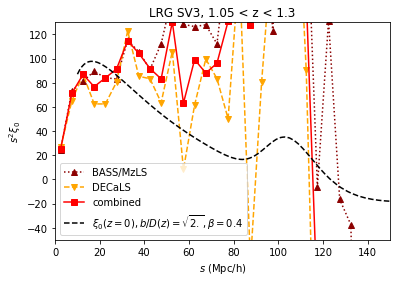

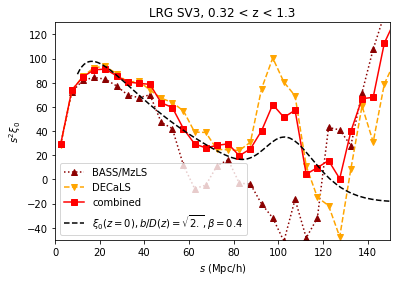

In [9]:
zl = [0.32,0.6,0.8,1.05,1.3]
for i in range(0,len(zl)):
    if i == len(zl)-1:
        zmin=zl[0]
        zmax=zl[-1]
    else:
        zmin = zl[i]
        zmax = zl[i+1]

    xils = np.loadtxt('/global/cscratch1/sd/ajross/SV3xi/xi024SV3_testLRGAlltiles_S'+str(zmin)+str(zmax)+'5st0.dat').transpose()
    xil = np.loadtxt('/global/cscratch1/sd/ajross/SV3xi/xi024SV3_testLRGAlltiles'+str(zmin)+str(zmax)+'5st0.dat').transpose()
    xiln = np.loadtxt('/global/cscratch1/sd/ajross/SV3xi/xi024SV3_testLRGAlltiles_N'+str(zmin)+str(zmax)+'5st0.dat').transpose()
    plt.plot(xil[0],xil[0]**2.*xiln[1],'^:',color='darkred',label='BASS/MzLS')
    plt.plot(xil[0],xil[0]**2.*xils[1],'v--',color='orange',label='DECaLS')
    plt.plot(xil[0],xil[0]**2.*xil[1],'s-r',label='combined')
    xilin = np.loadtxt(os.environ['HOME']+'/BAOtemplates/xi0Challenge_matterpower0.44.04.08.015.00.dat').transpose()
    #plt.plot(xilin[0],xilin[0]**2.*xilin[1]*2.2,'k-.',label=r'$\xi_{\rm 0}(z=0),b/D(z)=\sqrt{2.2},\beta=0.4$')
    #xilin = np.loadtxt(os.environ['HOME']+'/BAOtemplates/xi0Challenge_matterpower0.44.04.08.015.00.dat').transpose()
    plt.plot(xilin[0],xilin[0]**2.*xilin[1]*2.,'k--',label=r'$\xi_{\rm 0}(z=0),b/D(z)=\sqrt{2.},\beta=0.4$')
    #xilin = np.loadtxt(os.environ['HOME']+'/BAOtemplates/xi0Challenge_matterpower0.44.04.08.015.00.dat').transpose()
    #plt.plot(xilin[0],xilin[0]**2.*xilin[1]*1.8,'k:',label=r'$\xi_{\rm 0}(z=0),b/D(z)=\sqrt{1.8},\beta=0.4$')

    plt.title('LRG SV3, '+str(zmin)+' < z < '+str(zmax))
    plt.xlim(0,150)
    plt.ylim(-50,130)
    plt.xlabel(r'$s$ (Mpc/h)')
    plt.ylabel(r'$s^2\xi_0$')
    plt.legend()
    plt.show()

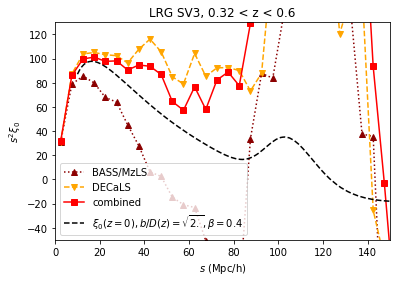

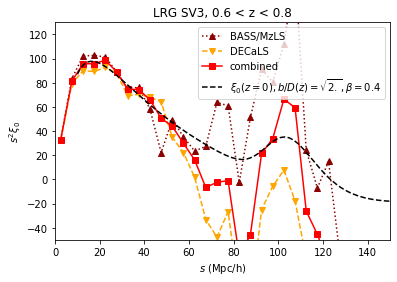

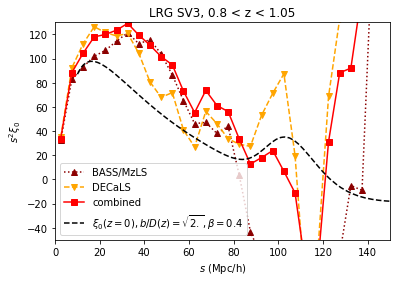

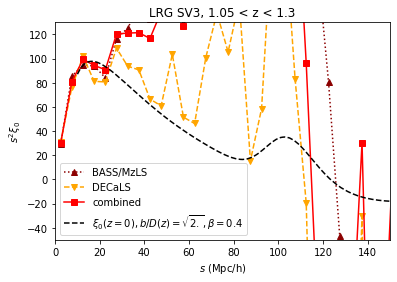

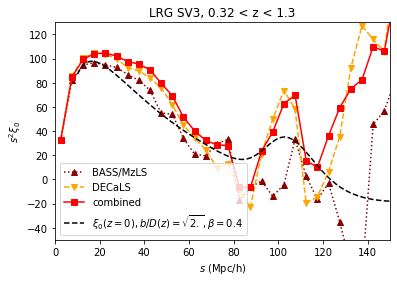

In [184]:
zl = [0.32,0.6,0.8,1.05,1.3]
for i in range(0,len(zl)):
    if i == len(zl)-1:
        zmin=zl[0]
        zmax=zl[-1]
    else:
        zmin = zl[i]
        zmax = zl[i+1]

    xiln = np.loadtxt('/global/cscratch1/sd/ajross/SV3xi/xi024SV3_testLRG_Nmint2'+str(zmin)+str(zmax)+'5st0.dat').transpose()
    plt.plot(xil[0],xil[0]**2.*xiln[1],'^:',color='darkred',label='BASS/MzLS')
    xils = np.loadtxt('/global/cscratch1/sd/ajross/SV3xi/xi024SV3_testLRG_Smint2'+str(zmin)+str(zmax)+'5st0.dat').transpose()
    plt.plot(xil[0],xil[0]**2.*xils[1],'v--',color='orange',label='DECaLS')
    xil = np.loadtxt('/global/cscratch1/sd/ajross/SV3xi/xi024SV3_testLRGmint2'+str(zmin)+str(zmax)+'5st0.dat').transpose()
    plt.plot(xil[0],xil[0]**2.*xil[1],'s-r',label='combined')
    xilin = np.loadtxt(os.environ['HOME']+'/BAOtemplates/xi0Challenge_matterpower0.44.04.08.015.00.dat').transpose()
    #plt.plot(xilin[0],xilin[0]**2.*xilin[1]*2.2,'k-.',label=r'$\xi_{\rm 0}(z=0),b/D(z)=\sqrt{2.2},\beta=0.4$')
    #xilin = np.loadtxt(os.environ['HOME']+'/BAOtemplates/xi0Challenge_matterpower0.44.04.08.015.00.dat').transpose()
    plt.plot(xilin[0],xilin[0]**2.*xilin[1]*2.,'k--',label=r'$\xi_{\rm 0}(z=0),b/D(z)=\sqrt{2.},\beta=0.4$')
    #xilin = np.loadtxt(os.environ['HOME']+'/BAOtemplates/xi0Challenge_matterpower0.44.04.08.015.00.dat').transpose()
    #plt.plot(xilin[0],xilin[0]**2.*xilin[1]*1.8,'k:',label=r'$\xi_{\rm 0}(z=0),b/D(z)=\sqrt{1.8},\beta=0.4$')

    plt.title('LRG SV3, '+str(zmin)+' < z < '+str(zmax))
    plt.xlim(0,150)
    plt.ylim(-50,130)
    plt.xlabel(r'$s$ (Mpc/h)')
    plt.ylabel(r'$s^2\xi_0$')
    plt.legend()
    plt.show()

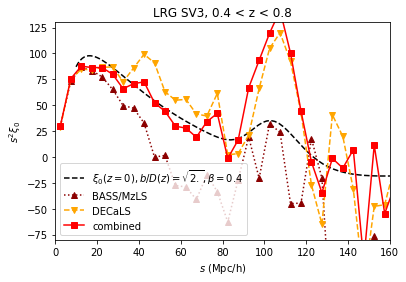

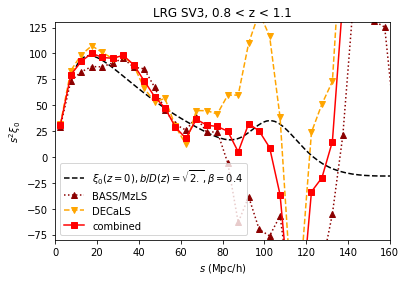

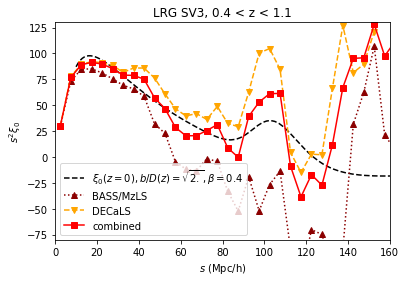

In [154]:
zl = [0.4,.8,1.1]
for i in range(0,len(zl)):
    if i == len(zl)-1:
        zmin=zl[0]
        zmax=zl[-1]
    else:
        zmin = zl[i]
        zmax = zl[i+1]
    xilin = np.loadtxt(os.environ['HOME']+'/BAOtemplates/xi0Challenge_matterpower0.44.04.08.015.00.dat').transpose()
    #plt.plot(xilin[0],xilin[0]**2.*xilin[1]*2.2,'k-.',label=r'$\xi_{\rm 0}(z=0),b/D(z)=\sqrt{2.2},\beta=0.4$')
    #xilin = np.loadtxt(os.environ['HOME']+'/BAOtemplates/xi0Challenge_matterpower0.44.04.08.015.00.dat').transpose()
    plt.plot(xilin[0],xilin[0]**2.*xilin[1]*2.,'k--',label=r'$\xi_{\rm 0}(z=0),b/D(z)=\sqrt{2.},\beta=0.4$')

    xiln = np.loadtxt('/global/cscratch1/sd/ajross/SV3xi/xi024SV3_1LRG_Nmint5'+str(zmin)+str(zmax)+'5st0.dat').transpose()
    plt.plot(xiln[0],xiln[0]**2.*xiln[1],'^:',color='darkred',label='BASS/MzLS')
    xils = np.loadtxt('/global/cscratch1/sd/ajross/SV3xi/xi024SV3_1LRG_Smint5'+str(zmin)+str(zmax)+'5st0.dat').transpose()
    plt.plot(xiln[0],xiln[0]**2.*xils[1],'v--',color='orange',label='DECaLS')
    xil = np.loadtxt('/global/cscratch1/sd/ajross/SV3xi/xi024SV3_1LRGmint5'+str(zmin)+str(zmax)+'5st0.dat').transpose()

    plt.plot(xil[0],xil[0]**2.*xil[1],'s-r',label='combined')
    #xilin = np.loadtxt(os.environ['HOME']+'/BAOtemplates/xi0Challenge_matterpower0.44.04.08.015.00.dat').transpose()
    #plt.plot(xilin[0],xilin[0]**2.*xilin[1]*1.8,'k:',label=r'$\xi_{\rm 0}(z=0),b/D(z)=\sqrt{1.8},\beta=0.4$')

    plt.title('LRG SV3, '+str(zmin)+' < z < '+str(zmax))
    plt.xlim(0,160)
    plt.ylim(-80,130)
    plt.xlabel(r'$s$ (Mpc/h)')
    plt.ylabel(r'$s^2\xi_0$')
    plt.legend()
    plt.show()

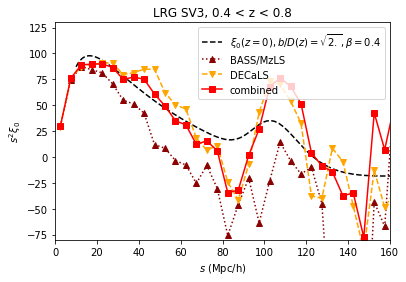

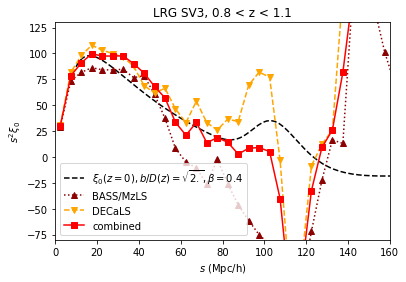

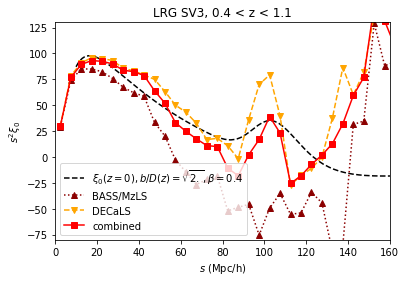

In [148]:
zl = [0.4,.8,1.1]
for i in range(0,len(zl)):
    if i == len(zl)-1:
        zmin=zl[0]
        zmax=zl[-1]
    else:
        zmin = zl[i]
        zmax = zl[i+1]
    xilin = np.loadtxt(os.environ['HOME']+'/BAOtemplates/xi0Challenge_matterpower0.44.04.08.015.00.dat').transpose()
    #plt.plot(xilin[0],xilin[0]**2.*xilin[1]*2.2,'k-.',label=r'$\xi_{\rm 0}(z=0),b/D(z)=\sqrt{2.2},\beta=0.4$')
    #xilin = np.loadtxt(os.environ['HOME']+'/BAOtemplates/xi0Challenge_matterpower0.44.04.08.015.00.dat').transpose()
    plt.plot(xilin[0],xilin[0]**2.*xilin[1]*2.,'k--',label=r'$\xi_{\rm 0}(z=0),b/D(z)=\sqrt{2.},\beta=0.4$')

    xiln = np.loadtxt('/global/cscratch1/sd/ajross/SV3xi/xi024SV3_testLRG_N'+str(zmin)+str(zmax)+'5st0.dat').transpose()
    plt.plot(xiln[0],xiln[0]**2.*xiln[1],'^:',color='darkred',label='BASS/MzLS')
    xils = np.loadtxt('/global/cscratch1/sd/ajross/SV3xi/xi024SV3_testLRG_S'+str(zmin)+str(zmax)+'5st0.dat').transpose()
    plt.plot(xiln[0],xiln[0]**2.*xils[1],'v--',color='orange',label='DECaLS')
    xil = np.loadtxt('/global/cscratch1/sd/ajross/SV3xi/xi024SV3_testLRG'+str(zmin)+str(zmax)+'5st0.dat').transpose()

    plt.plot(xil[0],xil[0]**2.*xil[1],'s-r',label='combined')
    #xilin = np.loadtxt(os.environ['HOME']+'/BAOtemplates/xi0Challenge_matterpower0.44.04.08.015.00.dat').transpose()
    #plt.plot(xilin[0],xilin[0]**2.*xilin[1]*1.8,'k:',label=r'$\xi_{\rm 0}(z=0),b/D(z)=\sqrt{1.8},\beta=0.4$')

    plt.title('LRG SV3, '+str(zmin)+' < z < '+str(zmax))
    plt.xlim(0,160)
    plt.ylim(-80,130)
    plt.xlabel(r'$s$ (Mpc/h)')
    plt.ylabel(r'$s^2\xi_0$')
    plt.legend()
    plt.show()

## clustering looks kind of funky...not sure what is going on

In [16]:
fc= fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/LSScats/test/LRGAlltiles_clustering.dat.fits')
fcr= fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/LSScats/test/LRGAlltiles_0_clustering.ran.fits')

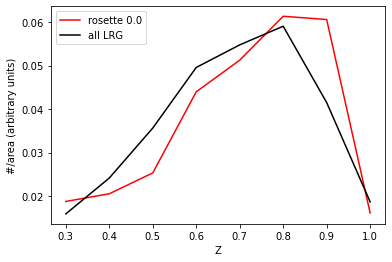

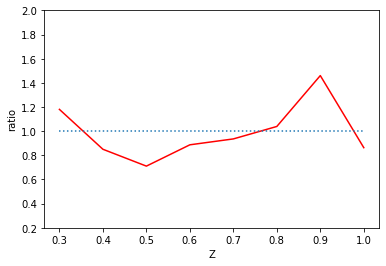

0.0 -0.004502978911438759 0.008268940627459618


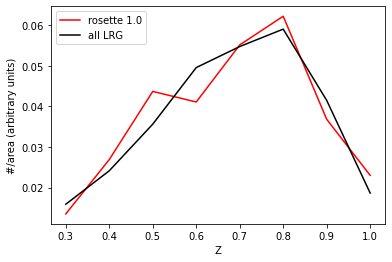

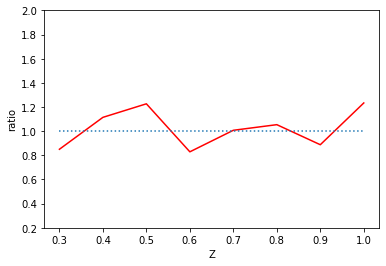

1.0 0.010819822677697686 0.004997183787727292


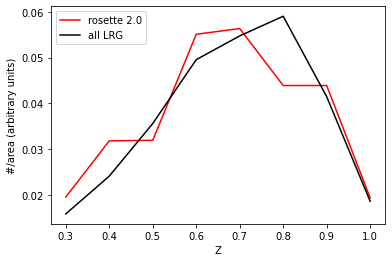

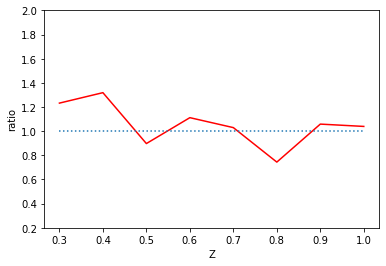

2.0 0.009721111819615215 0.006646511700985788


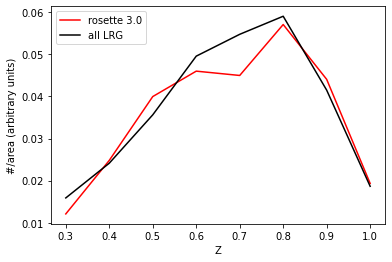

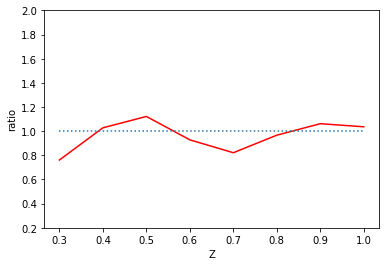

3.0 -0.03627502155577578 0.004153647531505144


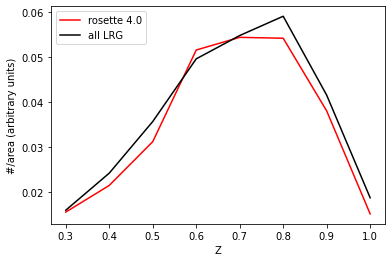

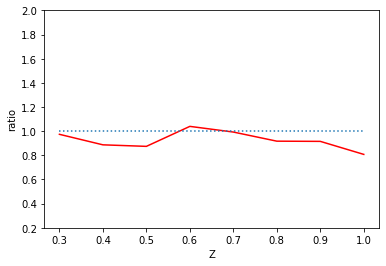

4.0 -0.06036236751736626 0.002238904396166461


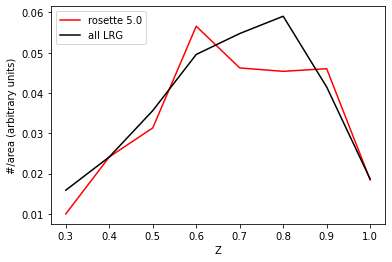

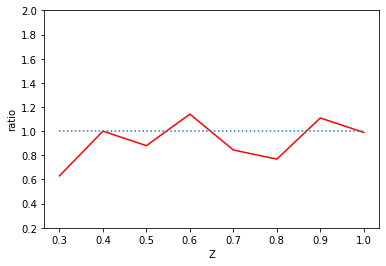

5.0 -0.0702850029047484 0.006390785577177066


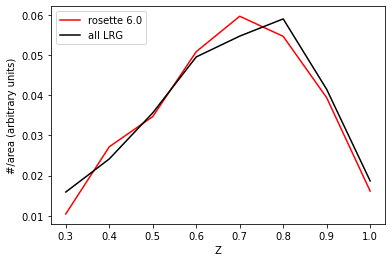

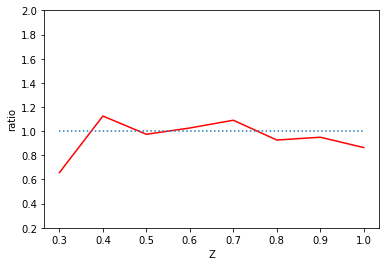

6.0 -0.02026620733761584 0.0033724643182726157


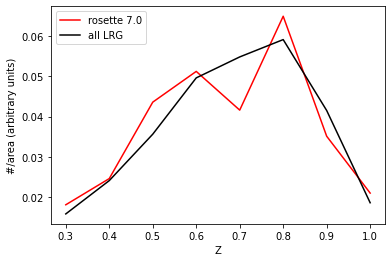

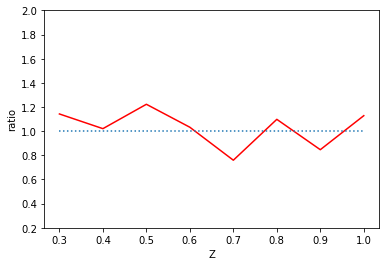

7.0 0.0031278511849701534 0.006359815104728737


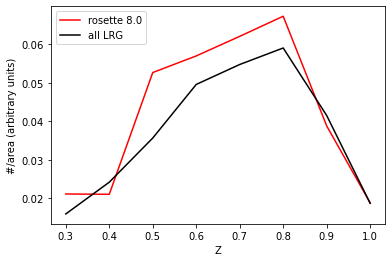

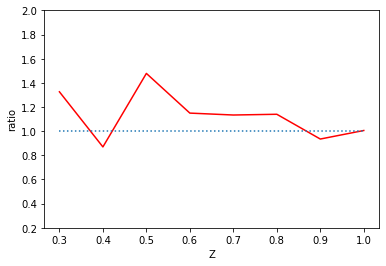

8.0 0.1318462206530808 0.006286809236675636


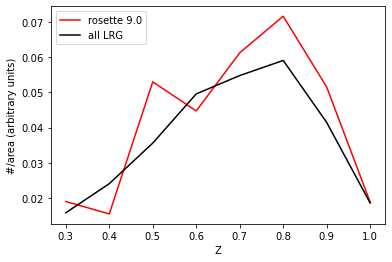

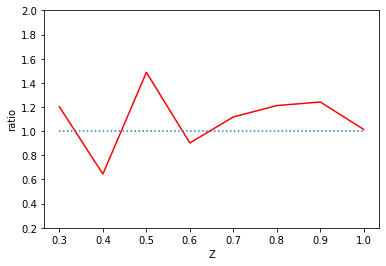

9.0 0.12157275282643165 0.008220210196038701


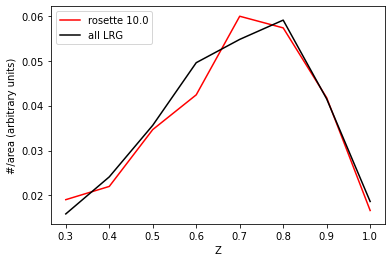

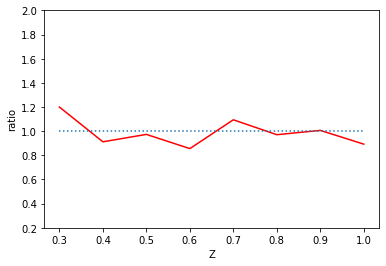

10.0 -0.017999219027690933 0.003476853320363105


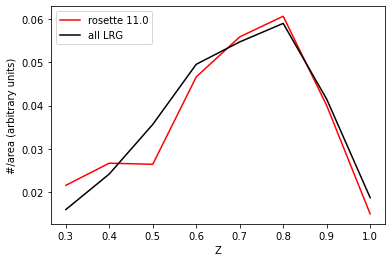

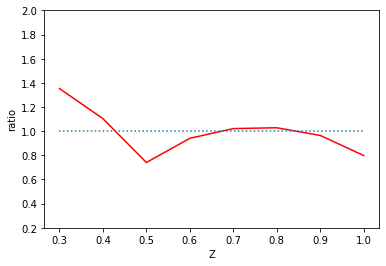

11.0 -0.021626406937502354 0.0042871390867284705


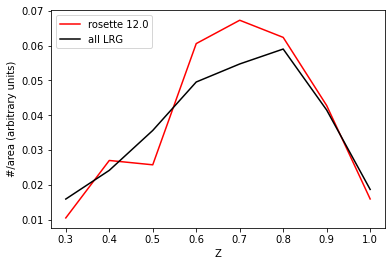

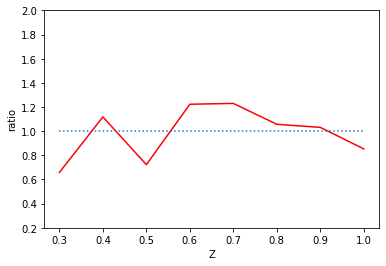

12.0 0.043680207126141284 0.007197108965579305


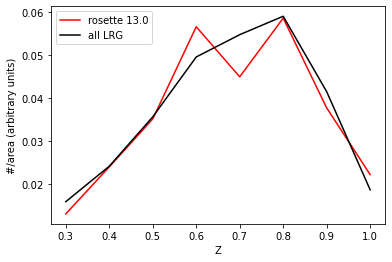

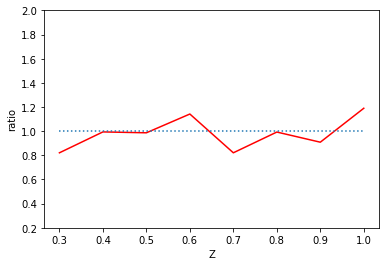

13.0 -0.023208602847193786 0.0046758432002443825


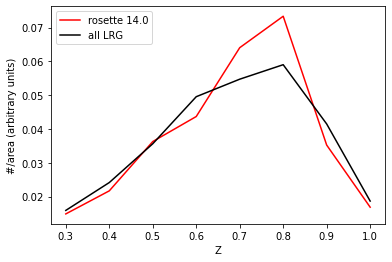

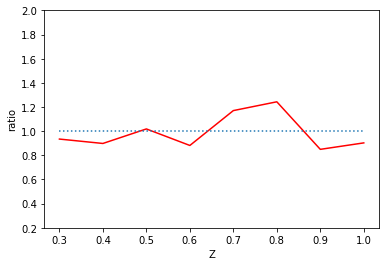

14.0 0.023077678331449844 0.006810732988702899


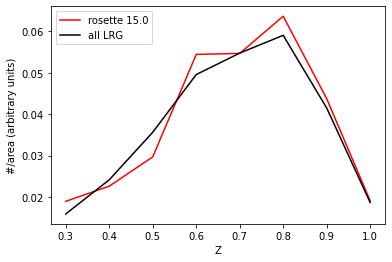

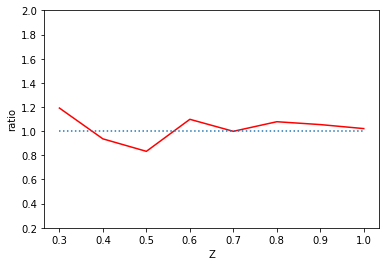

15.0 0.02546001546151112 0.003353613284776152


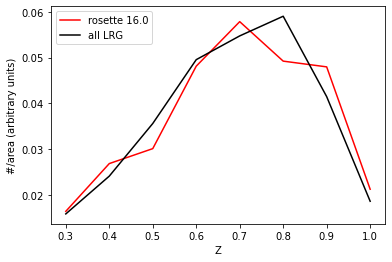

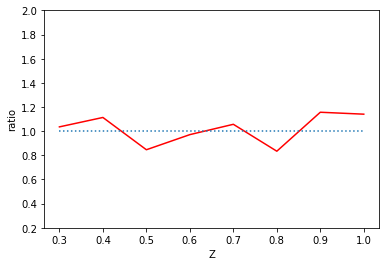

16.0 -0.003901917124887637 0.004929685435053572


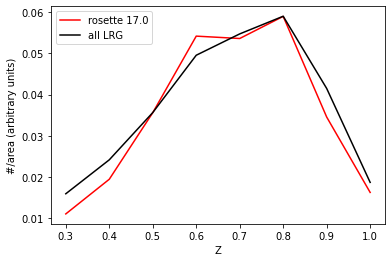

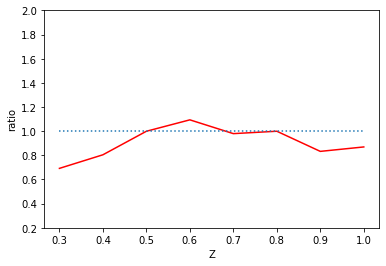

17.0 -0.051957037120114846 0.003410294595143784


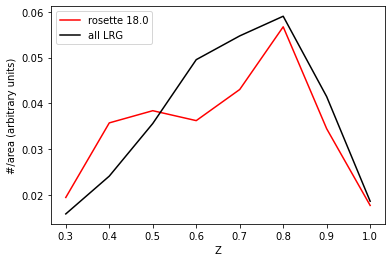

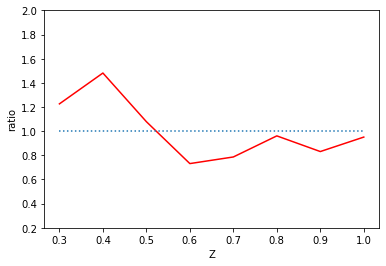

18.0 -0.05756259779293959 0.007807089955231978


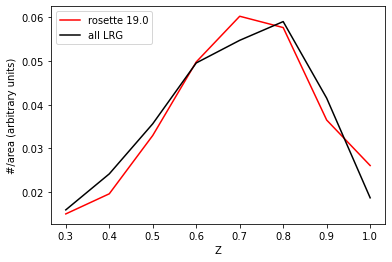

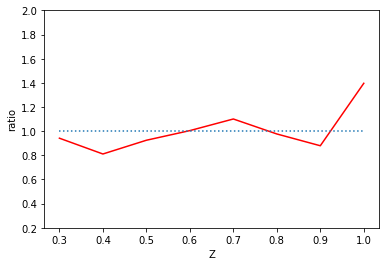

19.0 -0.00472551493149822 0.004194095657997819


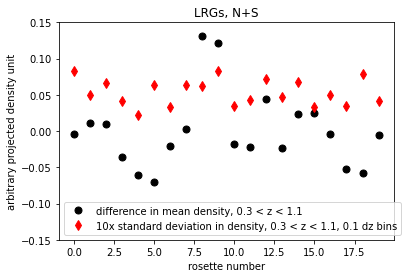

In [30]:
zmin = 0.3
zmax = 1.1
nbin = 8
normt = len(fcr)
zhistt,bins = np.histogram(fc['Z'],bins=nbin,range=(zmin,zmax),weights=fc['WEIGHT'])
rosl = []
ml = []
sl = []
for ros in np.unique(fc['rosette_number']):
    sel = fc['rosette_number'] == ros
    selr = fcr['rosette_number'] == ros
    norm = len(fcr[selr])
    zhist,t = np.histogram(fc[sel]['Z'],bins=nbin,range=(zmin,zmax),weights=fc[sel]['WEIGHT'])
    plt.plot(bins[:-1],zhist/norm,'r-',label='rosette '+str(ros))
    plt.plot(bins[:-1],zhistt/normt,'k-',label='all LRG')
    plt.xlabel('Z')
    plt.ylabel('#/area (arbitrary units)')
    plt.legend()
    plt.show()
    plt.plot(bins[:-1],zhist/norm/(zhistt/normt),'r-')
    plt.plot(bins[:-1],np.ones(len(zhist)),':')
    plt.ylabel('ratio')
    plt.xlabel('Z')
    plt.ylim(0.2,2)
    plt.show()
    md = (sum(zhist)/norm-sum(zhistt)/normt)/(sum(zhistt)/normt)
    sd = np.std(zhist/norm-zhistt/normt)
    rosl.append(ros)
    ml.append(md)
    sl.append(sd)
    print(ros,md,sd)
plt.plot(rosl,ml,'ko',ms=7,label='difference in mean density, 0.3 < z < 1.1')
plt.plot(rosl,np.array(sl)*10,'rd',ms=7,label='10x standard deviation in density, 0.3 < z < 1.1, 0.1 dz bins')
plt.xlabel('rosette number')
plt.legend()
plt.ylabel('arbitrary projected density unit')
plt.title("LRGs, N+S")
plt.ylim(-0.15,.15)
plt.show()
    

108871
104753
[   0    4   32   36 1024 1056 1060]
104753
103495
102806
0


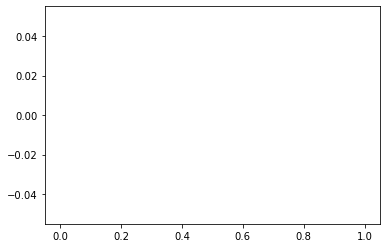

104753
103495


In [13]:
print(len(ff))
wz = ff['LOCATION_ASSIGNED'] == 1
print(len(ff[wz]))
print(np.unique(ff[wz]['ZWARN']))
wz &= ff['ZWARN'] != 999999
wz &= ff['ZWARN']*0 == 0
print(len(ff[wz]))
wz = ff['ZWARN'] == 0
print(len(ff[wz]))
wz &= ff['DELTACHI2'] > 16
print(len(ff[wz]))
wz = ff['ZWARN']*0 == 0
wz &= ff['ZWARN'] != 999999
wa = ff['LOCATION_ASSIGNED'] == 1
ww = wa & ~wz
print(len(ff[ww]))
plt.hist(ff[ww]['Z'])
plt.show()
print(len(ff[wz]))
wz &= ff['ZWARN'] == 0
print(len(ff[wz]))

In [67]:
np.max(ff[wz]['Z'])

5.990724067077254

In [41]:
np.unique(ff[~wz]['Z'])

array([1.e+20])

In [72]:
len(np.unique(ff[wz]['TILELOCID']))

97079

In [73]:
len(ff[wz])

97079

In [74]:
np.array_equal(ff[wz]['LOCATION'], ff[wz]['LOCATION_AVAIL'])

True

In [49]:
ld = ff[wz]['LOCATION'] - ff[wz]['LOCATION_AVAIL']

In [50]:
np.unique(ld,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 array([86092,  2180,    27,    45,    41,    92,    98,   121,   183,
          158,   142,   168,   234,   230,   244,   284,   228,   248,
          330,   309,   276,   444,   343,   162]))

In [14]:
ff.dtype.names

('RA',
 'DEC',
 'TARGETID',
 'SV3_DESI_TARGET',
 'SV3_BGS_TARGET',
 'SV3_MWS_TARGET',
 'SUBPRIORITY',
 'PRIORITY_INIT',
 'TARGET_STATE',
 'TIMESTAMP',
 'ZWARN_MTL',
 'FIBER',
 'LOCATION',
 'TILEID',
 'TILELOCID',
 'CHI2',
 'COEFF',
 'Z',
 'ZERR',
 'ZWARN',
 'NPIXELS',
 'SPECTYPE',
 'SUBTYPE',
 'NCOEFF',
 'DELTACHI2',
 'NUMEXP',
 'NUMTILE',
 'FIBERSTATUS',
 'OBJTYPE',
 'FIBERASSIGN_X',
 'FIBERASSIGN_Y',
 'PRIORITY',
 'DELTA_X',
 'DELTA_Y',
 'EXPTIME',
 'PSF_TO_FIBER_SPECFLUX',
 'INTEG_COADD_FLUX_B',
 'MEDIAN_COADD_FLUX_B',
 'MEDIAN_COADD_SNR_B',
 'INTEG_COADD_FLUX_R',
 'MEDIAN_COADD_FLUX_R',
 'MEDIAN_COADD_SNR_R',
 'INTEG_COADD_FLUX_Z',
 'MEDIAN_COADD_FLUX_Z',
 'MEDIAN_COADD_SNR_Z',
 'TSNR2_ELG_B',
 'TSNR2_LYA_B',
 'TSNR2_BGS_B',
 'TSNR2_QSO_B',
 'TSNR2_LRG_B',
 'TSNR2_ELG_R',
 'TSNR2_LYA_R',
 'TSNR2_BGS_R',
 'TSNR2_QSO_R',
 'TSNR2_LRG_R',
 'TSNR2_ELG_Z',
 'TSNR2_LYA_Z',
 'TSNR2_BGS_Z',
 'TSNR2_QSO_Z',
 'TSNR2_LRG_Z',
 'TSNR2_ELG',
 'TSNR2_LYA',
 'TSNR2_BGS',
 'TSNR2_QSO',
 'TSNR2_LRG',

In [62]:
f = fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/LSScats/test/ALL1_full.dat.fits')

In [52]:
f.dtype.names

('TARGETID',
 'FIBER',
 'LOCATION_AVAIL',
 'RA',
 'DEC',
 'REF_EPOCH',
 'PARALLAX',
 'PMRA',
 'PMDEC',
 'SV3_DESI_TARGET',
 'SV3_BGS_TARGET',
 'SV3_MWS_TARGET',
 'SUBPRIORITY',
 'OBSCONDITIONS',
 'PRIORITY_INIT',
 'NUMOBS_INIT',
 'SV3_SCND_TARGET',
 'NUMOBS_MORE',
 'NUMOBS',
 'ZTILEID',
 'TARGET_STATE',
 'TIMESTAMP',
 'VERSION',
 'RELEASE',
 'BRICKID',
 'BRICKNAME',
 'BRICK_OBJID',
 'MORPHTYPE',
 'EBV',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'MW_TRANSMISSION_G',
 'MW_TRANSMISSION_R',
 'MW_TRANSMISSION_Z',
 'FRACFLUX_G',
 'FRACFLUX_R',
 'FRACFLUX_Z',
 'FRACMASKED_G',
 'FRACMASKED_R',
 'FRACMASKED_Z',
 'FRACIN_G',
 'FRACIN_R',
 'FRACIN_Z',
 'NOBS_G',
 'NOBS_R',
 'NOBS_Z',
 'PSFDEPTH_G',
 'PSFDEPTH_R',
 'PSFDEPTH_Z',
 'GALDEPTH_G',
 'GALDEPTH_R',
 'GALDEPTH_Z',
 'FLUX_W1',
 'FLUX_W2',
 'FLUX_IVAR_W1',
 'FLUX_IVAR_W2',
 'MW_TRANSMISSION_W1',
 'MW_TRANSMISSION_W2',
 'ALLMASK_G',
 'ALLMASK_R',
 'ALLMASK_Z',
 'FIBERFLUX_G',
 'FIBERFLUX_R',
 'FIBERFLU

In [63]:
wz = f['LOCATION_ASSIGNED'] == 1

In [64]:
ld = f[wz]['LOCATION'] - f[wz]['LOCATION_AVAIL']

In [65]:
np.unique(ld)

array([0])

In [57]:
len(ld)

3256

49523
49523
49398
49398


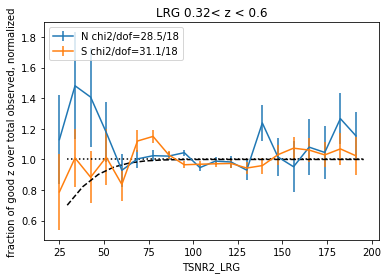

In [43]:
efac = 1#8.60
zmin = 0.32
zmax = 0.6
frl = [.225,.235]
regl = ['N','S']
for fr,reg in zip(frl,regl):
    wa = ff['LOCATION_ASSIGNED'] == 1
    wa &= ff['FIBERSTATUS'] == 0
    wa &= ff['TSNR2_LRG'] != 1e20
    wa &= ff['PHOTSYS'] == reg
    wgh = wa.copy()
    wgh &= ff['ZWARN'] == 0
    print(len(ff[wa]))
    wgh &= ff['Z'] > zmin
    wgh &= ff['Z'] < zmax
    print(len(ff[wa]))
    ffo = ff[wa]
    ffz = ff[wgh]
    rng = (25,200)
    nb = 20
    a = np.histogram(ffz['TSNR2_LRG'],bins=nb,range=rng)
    b = np.histogram(ffo['TSNR2_LRG'],bins=a[1])
    #plt.clf()
    dl = a[0]/b[0]/fr
    el = np.sqrt(a[0])/b[0]/fr
    vs = a[1][:-1]+bs/2.
    ol = np.ones(len(vs))#*0.74
    em = erf(vs/40)

    chi2 = np.sum((dl-1)**2./el**2.)
    plt.errorbar(a[1][:-1]*efac,dl,el,label=reg+' chi2/dof='+str(round(chi2,1))+'/'+str(nb-2))#,fmt='ko')
bs = (rng[1]-rng[0])/nb

ol = np.ones(len(vs))#*0.54
plt.plot(vs*efac,ol,'k:')
plt.plot(vs*efac,em,'k--')             
plt.title('LRG '+str(zmin)+'< z < '+str(zmax))
plt.xlabel('TSNR2_LRG')
plt.ylabel('fraction of good z over total observed, normalized')
plt.legend(loc='upper left')
plt.show()  

98921
98921


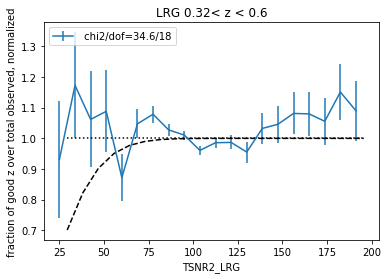

In [64]:
efac = 1#8.60
zmin = 0.32
zmax = 0.6
fr = .228
regl = ['N','S']
#for fr,reg in zip(frl,regl):
wa = ff['LOCATION_ASSIGNED'] == 1
wa &= ff['FIBERSTATUS'] == 0
wa &= ff['TSNR2_LRG'] != 1e20
#wa &= ff['PHOTSYS'] == reg
wgh = wa.copy()
wgh &= ff['ZWARN'] == 0
wgh &= ff['DELTACHI2'] > 16
print(len(ff[wa]))
wgh &= ff['Z'] > zmin
wgh &= ff['Z'] < zmax
print(len(ff[wa]))
ffo = ff[wa]
ffz = ff[wgh]
rng = (25,200)
nb = 20
a = np.histogram(ffz['TSNR2_LRG'],bins=nb,range=rng)
b = np.histogram(ffo['TSNR2_LRG'],bins=a[1])
#plt.clf()
dl = a[0]/b[0]/fr
el = np.sqrt(a[0])/b[0]/fr
vs = a[1][:-1]+bs/2.
ol = np.ones(len(vs))#*0.74
em = erf(vs/40)

chi2 = np.sum((dl-1)**2./el**2.)
plt.errorbar(a[1][:-1]*efac,dl,el,label=' chi2/dof='+str(round(chi2,1))+'/'+str(nb-2))#,fmt='ko')
bs = (rng[1]-rng[0])/nb

ol = np.ones(len(vs))#*0.54
plt.plot(vs*efac,ol,'k:')
plt.plot(vs*efac,em,'k--')             
plt.title('LRG '+str(zmin)+'< z < '+str(zmax))
plt.xlabel('TSNR2_LRG')
plt.ylabel('fraction of good z over total observed, normalized')
plt.legend(loc='upper left')
plt.show()  

98921
98921


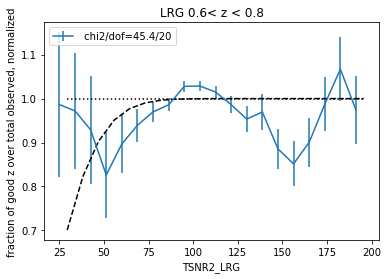

In [71]:
efac = 1#8.60
zmin = 0.6
zmax = 0.8
fr = .323
regl = ['N','S']
#for fr,reg in zip(frl,regl):
wa = ff['LOCATION_ASSIGNED'] == 1
wa &= ff['FIBERSTATUS'] == 0
wa &= ff['TSNR2_LRG'] != 1e20
#wa &= ff['PHOTSYS'] == reg
wgh = wa.copy()
wgh &= ff['ZWARN'] == 0
wgh &= ff['DELTACHI2'] > 16
print(len(ff[wa]))
wgh &= ff['Z'] > zmin
wgh &= ff['Z'] < zmax
print(len(ff[wa]))
ffo = ff[wa]
ffz = ff[wgh]
rng = (25,200)
nb = 20
a = np.histogram(ffz['TSNR2_LRG'],bins=nb,range=rng)
b = np.histogram(ffo['TSNR2_LRG'],bins=a[1])
#plt.clf()
dl = a[0]/b[0]/fr
el = np.sqrt(a[0])/b[0]/fr
vs = a[1][:-1]+bs/2.
ol = np.ones(len(vs))#*0.74
em = erf(vs/40)

chi2 = np.sum((dl-1)**2./el**2.)
plt.errorbar(a[1][:-1]*efac,dl,el,label=' chi2/dof='+str(round(chi2,1))+'/'+str(nb))#,fmt='ko')
bs = (rng[1]-rng[0])/nb

ol = np.ones(len(vs))#*0.54
plt.plot(vs*efac,ol,'k:')
plt.plot(vs*efac,em,'k--')             
plt.title('LRG '+str(zmin)+'< z < '+str(zmax))
plt.xlabel('TSNR2_LRG')
plt.ylabel('fraction of good z over total observed, normalized')
plt.legend(loc='upper left')
plt.show()  

131013
131013


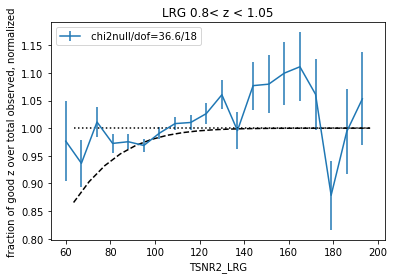

In [172]:
efac = 1#8.60
zmin = 0.8
zmax = 1.05
fr = .355
regl = ['N','S']
#for fr,reg in zip(frl,regl):
wa = ff['LOCATION_ASSIGNED'] == 1
wa &= ff['FIBERSTATUS'] == 0
wa &= ff['TSNR2_LRG'] != 1e20
#wa &= ff['PHOTSYS'] == reg
wgh = wa.copy()
wgh &= ff['ZWARN'] == 0
print(len(ff[wa]))
wgh &= ff['Z'] > zmin
wgh &= ff['Z'] < zmax
print(len(ff[wa]))
ffo = ff[wa]
ffz = ff[wgh]
rng = (60,200)
nb = 20
a = np.histogram(ffz['TSNR2_LRG'],bins=nb,range=rng,weights=ffz['WEIGHT_ZFAIL'])
b = np.histogram(ffo['TSNR2_LRG'],bins=a[1])
#plt.clf()
dl = a[0]/b[0]/fr
el = np.sqrt(a[0])/b[0]/fr
vs = a[1][:-1]+bs/2.
ol = np.ones(len(vs))#*0.74
em = erf(vs/60)

chi2 = np.sum((dl-em)**2./el**2.)
chi2n = np.sum((dl-1)**2./el**2.)
plt.errorbar(a[1][:-1]*efac,dl,el,label=' chi2null/dof='+str(round(chi2null,1))+'/'+str(nb-2))#,fmt='ko')
bs = (rng[1]-rng[0])/nb

ol = np.ones(len(vs))#*0.54
plt.plot(vs*efac,ol,'k:')
plt.plot(vs*efac,em,'k--')             
plt.title('LRG '+str(zmin)+'< z < '+str(zmax))
plt.xlabel('TSNR2_LRG')
plt.ylabel('fraction of good z over total observed, normalized')
plt.legend(loc='upper left')
plt.show()  

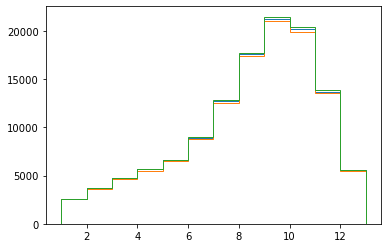

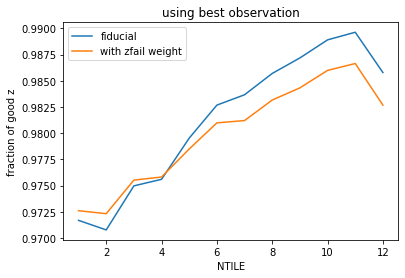

In [121]:
wa = ff['FIBERSTATUS'] == 0
wa &= ff['TSNR2_LRG'] != 1e20
wa &= ff['TSNR2_LRG'] > 70
wa &= ff['TSNR2_LRG'] < 150
wgh = wa & (ff['ZWARN'] == 0) & (ff['DELTACHI2'] > 16)
em = erf((ff[wgh]['TSNR2_LRG']-17)/40)*.98
efs = .08+2.52*(fibfluxz[wgh])**-4/.038
wtest = 1./(1. -(1.-em)*efs)
#wt = ff[wgh]['TSNR2_LRG'] > 150
#wtest[wt] = 1.
a = plt.hist(ff[wa]['NTILE'],histtype='step',bins=12)
b = plt.hist(ff[wa&wgh]['NTILE'],histtype='step',bins=12)
#c = plt.hist(ff[wa&wgh]['NTILE'],histtype='step',bins=12,weights=ff[wa&wgh]['WEIGHT_ZFAIL'])
c = plt.hist(ff[wa&wgh]['NTILE'],histtype='step',bins=12,weights=wtest)
plt.show()
plt.plot(a[1][:-1],b[0]/a[0],label='fiducial')
plt.plot(a[1][:-1],c[0]/a[0]*.975,label='with zfail weight')
plt.xlabel('NTILE')
plt.ylabel('fraction of good z')
plt.legend()
plt.title('using best observation')
#plt.ylim(0.96,1.01)
plt.show()

In [14]:
np.unique(ff[wa]['PRIORITY'],return_counts=True)

(array([     2,  83200,  83300,  93200,  93300, 103200, 103350, 103400],
       dtype=int32),
 array([  7235,    218,      2,   1481,      7, 121640,     20,    671]))

In [19]:
alld = fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/datcomb_dark_tarspecwdup_Alltiles.fits')

In [102]:
ftar = Table.read('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/dark_targets.fits')
ftar.keep_columns(['TARGETID','EBV','FLUX_G','FLUX_R','FLUX_Z','FLUX_IVAR_G','FLUX_IVAR_R','FLUX_IVAR_Z','MW_TRANSMISSION_G','MW_TRANSMISSION_R',\
        'MW_TRANSMISSION_Z','FRACFLUX_G','FRACFLUX_R','FRACFLUX_Z','FRACMASKED_G','FRACMASKED_R','FRACMASKED_Z','FRACIN_G','FRACIN_R',\
        'FRACIN_Z','NOBS_G','NOBS_R','NOBS_Z','PSFDEPTH_G','PSFDEPTH_R','PSFDEPTH_Z','GALDEPTH_G','GALDEPTH_R','GALDEPTH_Z','FLUX_W1',\
        'FLUX_W2','FLUX_IVAR_W1','FLUX_IVAR_W2','MW_TRANSMISSION_W1','MW_TRANSMISSION_W2','ALLMASK_G','ALLMASK_R','ALLMASK_Z','FIBERFLUX_G',\
        'FIBERFLUX_R','FIBERFLUX_Z','FIBERTOTFLUX_G','FIBERTOTFLUX_R','FIBERTOTFLUX_Z','WISEMASK_W1','WISEMASK_W2','MASKBITS',\
        'RELEASE','BRICKID','BRICKNAME','BRICK_OBJID','MORPHTYPE','PHOTSYS'])
dz = join(alld,ftar,keys=['TARGETID'])
print(len(alld),len(dz))

6318959 6318959


In [103]:
sel = dz['FIBERSTATUS'] == 0
sel &= ((dz['SV3_DESI_TARGET'] & sv3_targetmask.desi_mask['LRG'])> 0)

In [104]:
wp = dz['PRIORITY'] > 10000
print(len(dz[wp&sel]))

144970


In [105]:
fibfluxzt = dz['FIBERFLUX_Z']/dz['MW_TRANSMISSION_Z']

In [106]:
ft = dz[wp&sel]
fibfluxztt = fibfluxzt[wp&sel]

142125
138678


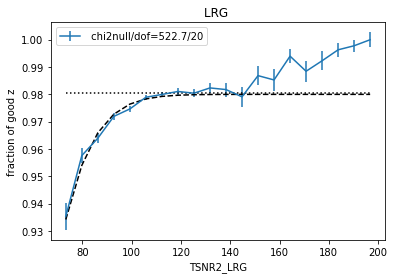

In [107]:
efac = 1#8.60
regl = ['N','S']
#for fr,reg in zip(frl,regl):
#wa = ff['LOCATION_ASSIGNED'] == 1
wa = ft['FIBERSTATUS'] == 0
wa &= ft['TSNR2_LRG'] != 1e20
wa &= ft['TSNR2_LRG'] > 70
#wa &= fibfluxz < 100
#wa &= ff['PHOTSYS'] == reg
wgh = wa & (ft['ZWARN'] == 0) & (ft['DELTACHI2'] > 16)
print(len(ft[wa]))
#wgh &= ff['Z'] > zmin
#wgh &= ff['Z'] < zmax

print(len(ft[wgh]))
ffo = ft[wa]
ffz = ft[wgh]
rng = (70,200)
nb = 20
bs = (rng[1]-rng[0])/nb
a = np.histogram(ffz['TSNR2_LRG'],bins=nb,range=rng)
b = np.histogram(ffo['TSNR2_LRG'],bins=a[1])
#plt.clf()
fr = np.mean(a[0]/b[0])
dl = a[0]/b[0]#/fr
varl = dl*b[0]*(1.-dl) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
el = np.sqrt(varl)/b[0]#/fr
vs = a[1][:-1]+bs/2.
ol = np.ones(len(vs))#*0.74
em = erf((vs-17)/40)*.98

chi2null = np.sum((dl-fr)**2./el**2.)
plt.errorbar(a[1][:-1]*efac+bs/2.,dl,el,label=' chi2null/dof='+str(round(chi2null,1))+'/'+str(nb))#,fmt='ko')


ol = np.ones(len(vs))*fr#*0.54
plt.plot(vs*efac,ol,'k:')
plt.plot(vs*efac,em,'k--')             
plt.title('LRG ')
plt.xlabel('TSNR2_LRG')
plt.ylabel('fraction of good z')
plt.legend(loc='upper left')
plt.show()  

30800
28663
0.9306168831168831
25.569958662176013 2.6399999999999877


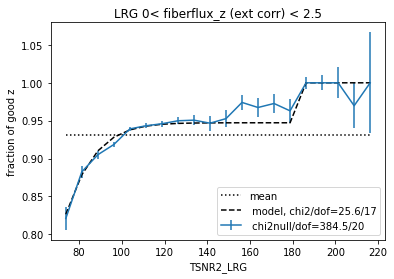

28273
27490
0.9723057333852085
31.98937773486501 1.0200000000000007


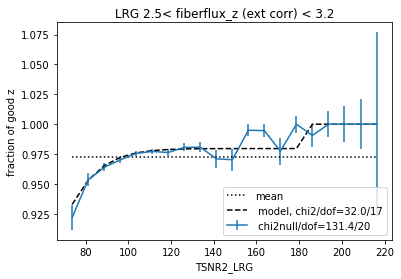

28071
27752
0.9886359588187097
21.34179275544219 0.4200000000000002


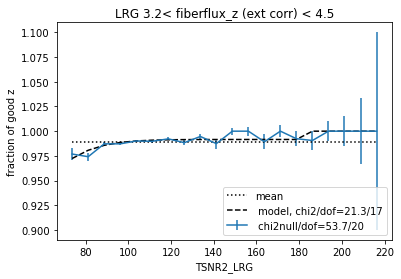

27358
27229
0.9952847430367717
8.146527658173714 0.17


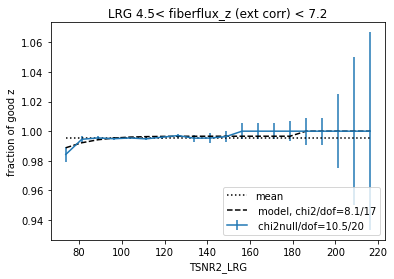

27623
27544
0.9971400644390545
8.43302535990954 0.09999999999999999


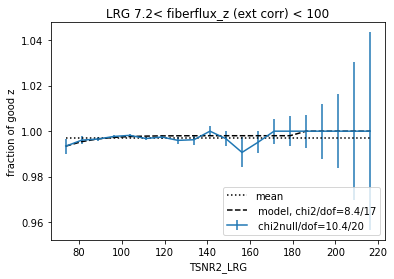

In [112]:
efac = 1#8.60
fs = [0,2.5,3.2,4.5,7.2]

#for fr,reg in zip(frl,regl):
#for c in nl:
cs = []
mfs = []
for i in range(0,len(fs)):
    #wa = ft['LOCATION_ASSIGNED'] == 1
    wa = ft['FIBERSTATUS'] == 0
    wa &= ft['TSNR2_LRG'] != 1e20
    wa &= ft['TSNR2_LRG'] > 70
    fm = fs[i]
    
    if i == len(fs)-1:
        fx = 100
    else:
        fx = fs[i+1]
    wa &= (fibfluxztt < fx)
    wa &= (fibfluxztt > fm)
    #wa &= ff['PHOTSYS'] == reg
    wgh = wa & (ft['ZWARN'] == 0) & (ft['DELTACHI2'] > 16)
    print(len(ft[wa]))
    #wgh &= ff['Z'] > zmin
    #wgh &= ff['Z'] < zmax

    print(len(ft[wgh]))
    ffo = ft[wa]
    ffz = ft[wgh]
    print(len(ffz)/len(ffo))
    rng = (70,220)
    nb = 20
    bs = (rng[1]-rng[0])/nb
    a = np.histogram(ffz['TSNR2_LRG'],bins=nb,range=rng)
    b = np.histogram(ffo['TSNR2_LRG'],bins=a[1])
    #plt.clf()
    fr = np.sum(a[0])/np.sum(b[0])
    dl = a[0]/b[0]#/fr
    varl = dl*b[0]*(1.-dl) #variance for binomial distribution
    wv = varl == 0
    varl[wv] = 1
    el = np.sqrt(varl)/b[0]#/fr
    #el = np.sqrt(b[0]-a[0])/b[0]
    #(nt*nnwt/nt*(1.-nnwt/nt))**.5/nt

    vs = a[1][:-1]+bs/2.
    ol = np.ones(len(vs))#*0.74
    #deg = 4
    #coeff = np.polyfit(vs,dl,deg,w=1/el)
    #em = erf((vs)/50)*.975
    #em = np.zeros(len(vs))
    #for i in range(0,deg+1):
    #    em += coeff[i]*vs**(deg-i)
    #em = coeff[0]*vs**4+coeff[1]*vs**3+coeff[2]*vs**2.+coeff[3]*vs +coeff[4]
    efi = 0
    chi2min = 1000
    wv = vs > 180
    while efi < 4:
        emfi = 1. -(1.-em)*efi
        emfi[wv] =1.
        chi2i = np.sum((dl-emfi)**2./el**2.)
        if chi2i < chi2min:
            chi2min = chi2i
            ef = efi
        efi += 0.01
    print(chi2min,ef)
    cs.append(ef)
    mfs.append(np.mean(fibfluxztt[wa]))
    emf = 1. -(1.-em)*ef
    
    emf[wv] =1.
    chi2m = np.sum((dl-emf)**2./el**2.)
    chi2null = np.sum((dl-fr)**2./el**2.)
    
    plt.errorbar(a[1][:-1]*efac+bs/2.,dl,el,label=' chi2null/dof='+str(round(chi2null,1))+'/'+str(nb))#,fmt='ko')


    ol = np.ones(len(vs))*fr#*0.54
    plt.plot(vs*efac,ol,'k:',label='mean')
    plt.plot(vs*efac,emf,'k--',label=' model, chi2/dof='+str(round(chi2m,1))+'/'+str(nb-3))             
    plt.title('LRG '+ str(fm)+'< fiberflux_z (ext corr) < '+str(fx))
    #if c == 0:
    #    plt.title('LRG fiberflux_z (ext corr) < '+str(fx))
    #else:
    #    plt.title('LRG fiberflux_z (ext corr) > '+str(fx))
    plt.xlabel('TSNR2_LRG')
    plt.ylabel('fraction of good z')
    plt.legend(loc='lower right')
    plt.show()  

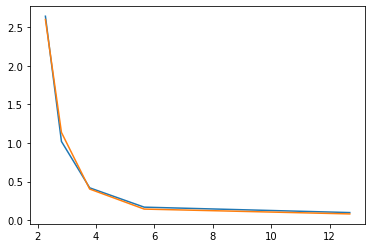

In [119]:
plt.plot(mfs,cs)
plt.plot(mfs,.08+2.52*(np.array(mfs))**-4/.038)

In [45]:
dtl = Table.read('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/LSScats/test/Alltiles_dark_tilelocs.dat.fits')
dtl.keep_columns(['TARGETID','NTILE','TILES','TILELOCIDS'])
dz = join(ft,dtl,keys='TARGETID')
print(len(dz),len(ft))

144970 144970


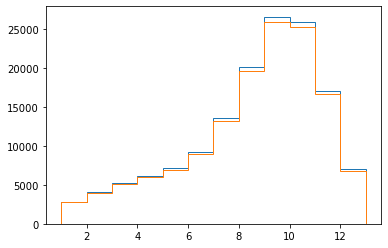

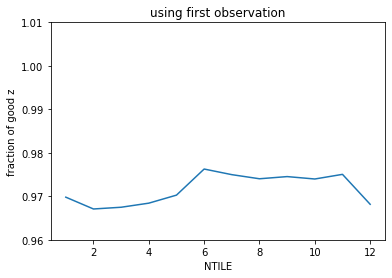

In [51]:
wa = dz['FIBERSTATUS'] == 0
wa &= dz['TSNR2_LRG'] != 1e20
wgh = wa & (dz['ZWARN'] == 0) & (dz['DELTACHI2'] > 16)

a = plt.hist(dz[wa]['NTILE'],histtype='step',bins=12)
b = plt.hist(dz[wa&wgh]['NTILE'],histtype='step',bins=12)
#c = plt.hist(ft[wa&wgh]['NTILE'],histtype='step',bins=12,weights=ft[wa&wgh]['WEIGHT_ZFAIL'])
plt.show()
plt.plot(a[1][:-1],b[0]/a[0])
plt.xlabel('NTILE')
plt.ylabel('fraction of good z')
plt.title('using first observation')
plt.ylim(0.96,1.01)
plt.show()
#plt.plot(a[1][:-1],c[0]/a[0])

In [89]:
fibfluxz = ff['FIBERFLUX_Z']/ff['MW_TRANSMISSION_Z']

(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,  9900., 12744., 10279.,  8617.,  7173.,  6116.,
         5464.,  4869.,  4332.,  3983.,  3582.,  3253.,  3213.,  2911.,
         2631.,  2386.,  2321.,  2117.,  1939.,  1865.,  1701.,  1645.,
         1647.,  1468.,  1373.,  1250.,  1251.,  1106.,  1096.,   997.,
          902.,   930.,   905.,   779.,   770.,   776.,   654.,   635.,
          602.,   619.,   554.,   515.,   505.,   501.,   502.,   417.,
          389.,   394.,   367.,   382.,   344.,   290.,   311.,   312.,
          327.,   281.,   259.,   257.,   252.,   266.,   225.,   233.,
          200.,   207.,   206.,   180.,   184.,   187.,   185.,   177.,
          162.,   158.,   149.,   153.,   153.,   143.,   138.,   125.,
          149.,   145.,   128.,   104.,   112.,    98.,   108.,    95.,
          107.,    99.,    91.,   105.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
         2.2,  2.4, 

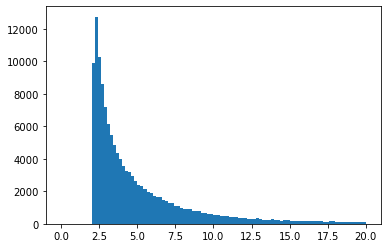

In [57]:
plt.hist(fibfluxz,bins=100,range=(0,20))

In [55]:
ps = np.arange(.2,1,.2)

In [58]:
for p in ps:
    print(np.percentile(fibfluxz,p*100))

2.48248610496521
3.1815501689910892
4.465445804595948
7.162351894378663


In [73]:
np.percentile(ff[wa]['TSNR2_LRG'],95)

146.3694282531738

131274
129904


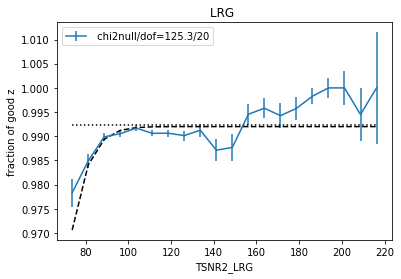

In [54]:
efac = 1#8.60
regl = ['N','S']
#for fr,reg in zip(frl,regl):
wa = ff['LOCATION_ASSIGNED'] == 1
wa &= ff['FIBERSTATUS'] == 0
wa &= ff['TSNR2_LRG'] != 1e20
#wa &= fibfluxz < 100
#wa &= ff['PHOTSYS'] == reg
wgh = wa & (ff['ZWARN'] == 0)
print(len(ff[wa]))
#wgh &= ff['Z'] > zmin
#wgh &= ff['Z'] < zmax

print(len(ff[wgh]))
ffo = ff[wa]
ffz = ff[wgh]
rng = (70,220)
nb = 20
bs = (rng[1]-rng[0])/nb
a = np.histogram(ffz['TSNR2_LRG'],bins=nb,range=rng)
b = np.histogram(ffo['TSNR2_LRG'],bins=a[1])
#plt.clf()
fr = np.mean(a[0]/b[0])
dl = a[0]/b[0]#/fr
varl = dl*b[0]*(1.-dl) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
el = np.sqrt(varl)/b[0]#/fr

vs = a[1][:-1]+bs/2.
ol = np.ones(len(vs))#*0.74


chi2null = np.sum((dl-fr)**2./el**2.)
plt.errorbar(a[1][:-1]*efac+bs/2.,dl,el,label=' chi2null/dof='+str(round(chi2null,1))+'/'+str(nb))#,fmt='ko')

em = erf((vs-25)/30)*.992
ol = np.ones(len(vs))*fr#*0.54
plt.plot(vs*efac,ol,'k:')
plt.plot(vs*efac,em,'k--')             
plt.title('LRG ')
plt.xlabel('TSNR2_LRG')
plt.ylabel('fraction of good z')
plt.legend(loc='upper left')
plt.show()  

In [55]:
wt = ffo['TSNR2_LRG'] > 200
len(ffo[wt])

506

In [61]:
np.unique(ffo[wt]['TARGETID'])

array([39627746145468505, 39627752160105040, 39627752164298428,
       39627752168491130, 39627752168491381, 39627752172683840,
       39627752172684554, 39627758199898179, 39627758204093163,
       39627758204097764, 39627758208287058, 39627758208287429,
       39627758208288822, 39627758208293263, 39627758208293536,
       39627758212483900, 39627758212484987, 39627758220870466,
       39627764239701974, 39627764243890372, 39627764243890918,
       39627764252281080, 39627764252283717, 39627764256473728,
       39627764273250359, 39627770275305012, 39627770279496434,
       39627770283689516, 39627770283691174, 39627770287888030,
       39627770292077409, 39627770292081364, 39627770292081731,
       39627770292082517, 39627770304664166, 39627770308855219,
       39627770308857291, 39627776315100883, 39627776319291824,
       39627776319292156, 39627776319294378, 39627776323488622,
       39627776323489168, 39627776323490560, 39627776327683420,
       39627776331877139, 39627776331877

130104
127941
0.9833748385906659


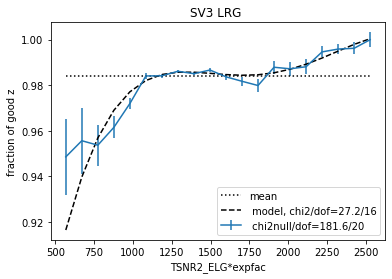

In [75]:
efac = 8.60
wa = ff['LOCATION_ASSIGNED'] == 1
wa &= ff['FIBERSTATUS'] == 0
wa &= ff['TSNR2_LRG'] != 1e20
wgh = wa & (ff['ZWARN'] == 0) & (ff['DELTACHI2'] > 16)
print(len(ff[wa]))
#wgh &= ff['Z'] > zmin
#wgh &= ff['Z'] < zmax

print(len(ff[wgh]))
ffo = ff[wa]
ffz = ff[wgh]
print(len(ffz)/len(ffo))
rng = (60,300)
nb = 20
bs = (rng[1]-rng[0])/nb
a = np.histogram(ffz['TSNR2_ELG'],bins=nb,range=rng)
b = np.histogram(ffo['TSNR2_ELG'],bins=a[1])
#plt.clf()
fr = np.sum(a[0])/np.sum(b[0])
dl = a[0]/b[0]#/fr
varl = dl*b[0]*(1.-dl) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
el = np.sqrt(varl)/b[0]#/fr
#el = np.sqrt(b[0]-a[0])/b[0]
#(nt*nnwt/nt*(1.-nnwt/nt))**.5/nt

vs = a[1][:-1]+bs/2.
ol = np.ones(len(vs))#*0.74
deg = 4
coeff = np.polyfit(vs,1-dl,deg,w=1/el)
#em = erf((vs)/50)*.975
em = np.zeros(len(vs))
for i in range(0,deg+1):
    em += coeff[i]*vs**(deg-i)
#em = coeff[0]*vs**4+coeff[1]*vs**3+coeff[2]*vs**2.+coeff[3]*vs +coeff[4]
chi2null = np.sum((dl-fr)**2./el**2.)
chi2m = np.sum((dl+em-1)**2./el**2.)
plt.errorbar((a[1][:-1]+bs/2.)*efac,dl,el,label=' chi2null/dof='+str(round(chi2null,1))+'/'+str(nb))#,fmt='ko')


ol = np.ones(len(vs))*fr#*0.54
plt.plot(vs*efac,ol,'k:',label='mean')
plt.plot(vs*efac,1-em,'k--',label=' model, chi2/dof='+str(round(chi2m,1))+'/'+str(nb-deg))             
plt.title('SV3 LRG ')
plt.xlabel('TSNR2_ELG*expfac')
plt.ylabel('fraction of good z')
plt.legend(loc='lower right')
plt.show()  

130104
127941
0.9833748385906659


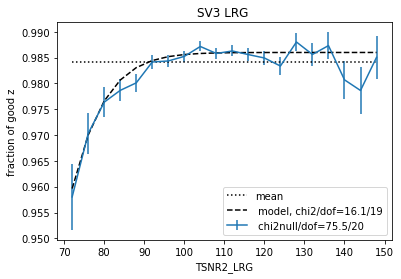

In [112]:
efac = 1#8.60
wa = ff['LOCATION_ASSIGNED'] == 1
wa &= ff['FIBERSTATUS'] == 0
wa &= ff['TSNR2_LRG'] != 1e20
wgh = wa & (ff['ZWARN'] == 0) & (ff['DELTACHI2'] > 16)
print(len(ff[wa]))
#wgh &= ff['Z'] > zmin
#wgh &= ff['Z'] < zmax

print(len(ff[wgh]))
ffo = ff[wa]
ffz = ff[wgh]
print(len(ffz)/len(ffo))
rng = (70,150)
nb = 20
bs = (rng[1]-rng[0])/nb
a = np.histogram(ffz['TSNR2_LRG'],bins=nb,range=rng)
b = np.histogram(ffo['TSNR2_LRG'],bins=a[1])
#plt.clf()
fr = np.sum(a[0])/np.sum(b[0])
dl = a[0]/b[0]#/fr
varl = dl*b[0]*(1.-dl) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
el = np.sqrt(varl)/b[0]#/fr
#el = np.sqrt(b[0]-a[0])/b[0]
#(nt*nnwt/nt*(1.-nnwt/nt))**.5/nt

vs = a[1][:-1]+bs/2.
ol = np.ones(len(vs))#*0.74
deg = 1
#coeff = np.polyfit(vs**.5,1-dl,deg,w=1/el)
em = erf((vs-25)/30)*.986
#em = np.zeros(len(vs))
#for i in range(0,deg+1):
#    em += coeff[i]*vs**(.5*(deg-i))
#em = coeff[0]*vs**4+coeff[1]*vs**3+coeff[2]*vs**2.+coeff[3]*vs +coeff[4]
chi2null = np.sum((dl-fr)**2./el**2.)
chi2m = np.sum((dl-em)**2./el**2.)
plt.errorbar(a[1][:-1]*efac+bs/2.,dl,el,label=' chi2null/dof='+str(round(chi2null,1))+'/'+str(nb))#,fmt='ko')


ol = np.ones(len(vs))*fr#*0.54
plt.plot(vs*efac,ol,'k:',label='mean')
plt.plot(vs*efac,em,'k--',label=' model, chi2/dof='+str(round(chi2m,1))+'/'+str(nb-deg))             
plt.title('SV3 LRG ')
plt.xlabel('TSNR2_LRG')
plt.ylabel('fraction of good z')
plt.legend(loc='lower right')
plt.show()  

131013
128879
0.9837115400761757
[ 1990  4524  9457 15110 19935 21705 18951 13539  8489  4669  2745  1713
  1179   906   828   767   645   548   449   377]
[ 1980.74454379  4510.00468969  9410.37539113 15073.95874095
 19905.61972845 21691.56256735 18932.55784523 13502.12455785
  8460.84284639  4664.56029892  2736.03185177  1703.03051984
  1179.98279476   907.75977087   834.03075314   768.63038695
   646.96559072   546.           448.           377.        ]
[ 68.67908217 102.6813623  191.05340754 236.43469369 280.58586123
 286.82232006 257.74892745 206.43620529 134.55221867  64.93819221
  43.85624826  31.81376336  14.01167017  10.01942352   4.02913407
   8.01700534   5.01523714   1.99270073   0.99777283   1.        ]


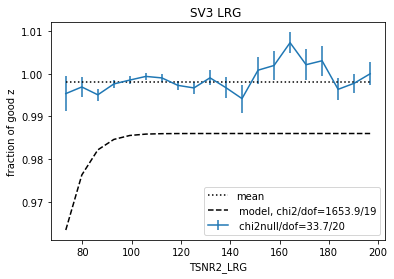

In [173]:
efac = 1#8.60
wa = ff['LOCATION_ASSIGNED'] == 1
wa &= ff['FIBERSTATUS'] == 0
wa &= ff['TSNR2_LRG'] != 1e20
wgh = wa & (ff['ZWARN'] == 0) & (ff['DELTACHI2'] > 16)
print(len(ff[wa]))
#wgh &= ff['Z'] > zmin
#wgh &= ff['Z'] < zmax

print(len(ff[wgh]))
ffo = ff[wa]
ffz = ff[wgh]
print(len(ffz)/len(ffo))
rng = (70,200)
nb = 20
bs = (rng[1]-rng[0])/nb
a = np.histogram(ffz['TSNR2_LRG'],bins=nb,range=rng,weights=ffz['WEIGHT_ZFAIL'])#,weights=1./zw[wgh])
b = np.histogram(ffo['TSNR2_LRG'],bins=a[1])
c = np.histogram(ffz['TSNR2_LRG'],bins=nb,range=rng)
print(b[0])
print(a[0])
#plt.clf()
fr = np.sum(a[0])/np.sum(b[0])
dl = a[0]/b[0]#/fr
dlv = c[0]/b[0]
varl = dl*b[0]*(1.-dlv) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
print(varl)
el = np.sqrt(varl)/b[0]#/fr
#el = np.sqrt(b[0]-a[0])/b[0]
#(nt*nnwt/nt*(1.-nnwt/nt))**.5/nt

vs = a[1][:-1]+bs/2.
ol = np.ones(len(vs))#*0.74
deg = 1
#coeff = np.polyfit(vs**.5,1-dl,deg,w=1/el)
em = erf((vs-25)/30)*.986
#em = np.zeros(len(vs))
#for i in range(0,deg+1):
#    em += coeff[i]*vs**(.5*(deg-i))
#em = coeff[0]*vs**4+coeff[1]*vs**3+coeff[2]*vs**2.+coeff[3]*vs +coeff[4]
chi2null = np.sum((dl-fr)**2./el**2.)
chi2m = np.sum((dl-em)**2./el**2.)
plt.errorbar(a[1][:-1]*efac+bs/2.,dl,el,label=' chi2null/dof='+str(round(chi2null,1))+'/'+str(nb))#,fmt='ko')


ol = np.ones(len(vs))*fr#*0.54
plt.plot(vs*efac,ol,'k:',label='mean')
plt.plot(vs*efac,em,'k--',label=' model, chi2/dof='+str(round(chi2m,1))+'/'+str(nb-deg))             
plt.title('SV3 LRG ')
plt.xlabel('TSNR2_LRG')
plt.ylabel('fraction of good z')
plt.legend(loc='lower right')
plt.show()  

26937
25645
0.952036232691094
15.485951735501276 2.5199999999999902


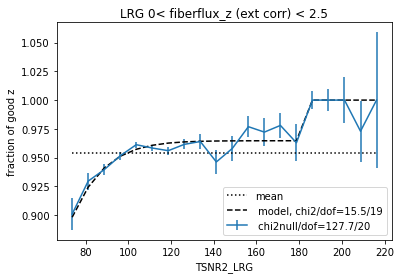

25680
25165
0.9799454828660437
23.91778574441954 0.9500000000000006


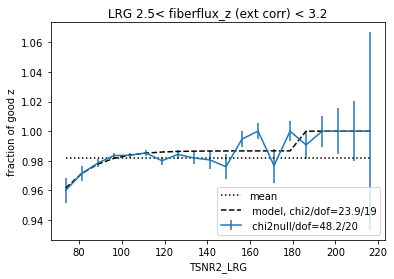

26011
25798
0.9918111568182691
15.816776138847803 0.37000000000000016


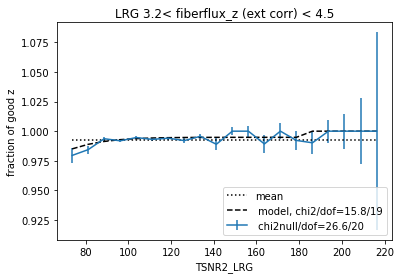

25683
25592
0.9964568002180431
11.519048426785561 0.13999999999999999


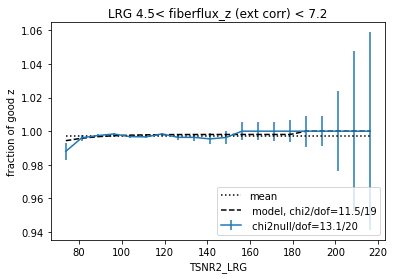

25793
25741
0.9979839491334859
16.910271371945917 0.08


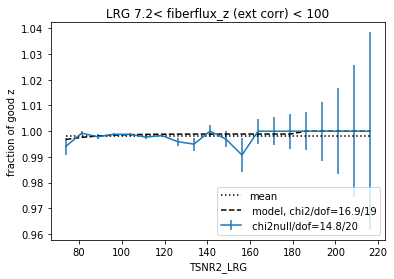

In [119]:
efac = 1#8.60
fs = [0,2.5,3.2,4.5,7.2]

#for fr,reg in zip(frl,regl):
#for c in nl:
cs = []
mfs = []
for i in range(0,len(fs)):
    wa = ff['LOCATION_ASSIGNED'] == 1
    wa &= ff['FIBERSTATUS'] == 0
    wa &= ff['TSNR2_LRG'] != 1e20
    fm = fs[i]
    
    if i == len(fs)-1:
        fx = 100
    else:
        fx = fs[i+1]
    wa &= (fibfluxz < fx)
    wa &= (fibfluxz > fm)
    #wa &= ff['PHOTSYS'] == reg
    wgh = wa & (ff['ZWARN'] == 0) & (ff['DELTACHI2'] > 16)
    print(len(ff[wa]))
    #wgh &= ff['Z'] > zmin
    #wgh &= ff['Z'] < zmax

    print(len(ff[wgh]))
    ffo = ff[wa]
    ffz = ff[wgh]
    print(len(ffz)/len(ffo))
    rng = (70,220)
    nb = 20
    bs = (rng[1]-rng[0])/nb
    a = np.histogram(ffz['TSNR2_LRG'],bins=nb,range=rng)
    b = np.histogram(ffo['TSNR2_LRG'],bins=a[1])
    #plt.clf()
    fr = np.sum(a[0])/np.sum(b[0])
    dl = a[0]/b[0]#/fr
    varl = dl*b[0]*(1.-dl) #variance for binomial distribution
    wv = varl == 0
    varl[wv] = 1
    el = np.sqrt(varl)/b[0]#/fr
    #el = np.sqrt(b[0]-a[0])/b[0]
    #(nt*nnwt/nt*(1.-nnwt/nt))**.5/nt

    vs = a[1][:-1]+bs/2.
    ol = np.ones(len(vs))#*0.74
    #deg = 4
    #coeff = np.polyfit(vs,dl,deg,w=1/el)
    #em = erf((vs)/50)*.975
    #em = np.zeros(len(vs))
    #for i in range(0,deg+1):
    #    em += coeff[i]*vs**(deg-i)
    #em = coeff[0]*vs**4+coeff[1]*vs**3+coeff[2]*vs**2.+coeff[3]*vs +coeff[4]
    efi = 0
    chi2min = 1000
    wv = vs > 180
    while efi < 4:
        emfi = 1. -(1.-em)*efi
        emfi[wv] =1.
        chi2i = np.sum((dl-emfi)**2./el**2.)
        if chi2i < chi2min:
            chi2min = chi2i
            ef = efi
        efi += 0.01
    print(chi2min,ef)
    cs.append(ef)
    mfs.append(np.mean(fibfluxz[wa]))
    emf = 1. -(1.-em)*ef
    
    emf[wv] =1.
    chi2m = np.sum((dl-emf)**2./el**2.)
    chi2null = np.sum((dl-fr)**2./el**2.)
    
    plt.errorbar(a[1][:-1]*efac+bs/2.,dl,el,label=' chi2null/dof='+str(round(chi2null,1))+'/'+str(nb))#,fmt='ko')


    ol = np.ones(len(vs))*fr#*0.54
    plt.plot(vs*efac,ol,'k:',label='mean')
    plt.plot(vs*efac,emf,'k--',label=' model, chi2/dof='+str(round(chi2m,1))+'/'+str(nb-deg))             
    plt.title('LRG '+ str(fm)+'< fiberflux_z (ext corr) < '+str(fx))
    #if c == 0:
    #    plt.title('LRG fiberflux_z (ext corr) < '+str(fx))
    #else:
    #    plt.title('LRG fiberflux_z (ext corr) > '+str(fx))
    plt.xlabel('TSNR2_LRG')
    plt.ylabel('fraction of good z')
    plt.legend(loc='lower right')
    plt.show()  

47076
45369
0.9637394850879429
29.163413375666135 0.25000000000000006


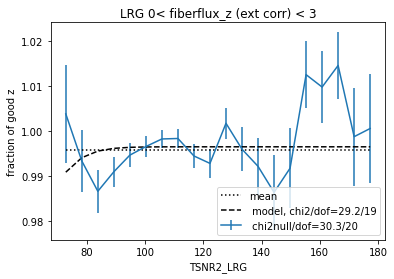

13553
13395
0.9883420644875673
7.474221518840001 0


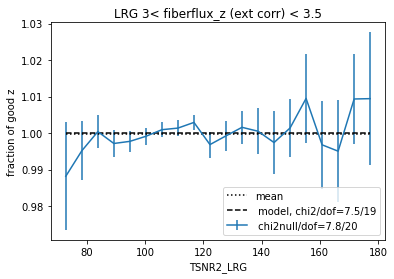

18512
18385
0.9931395851339672
10.73178183235571 0.02


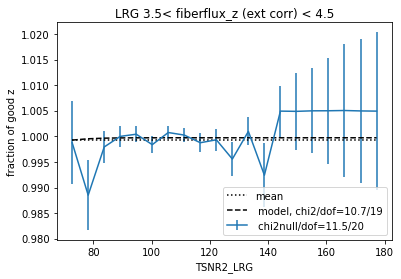

25860
25772
0.9965970610982212
14.224556822278002 0


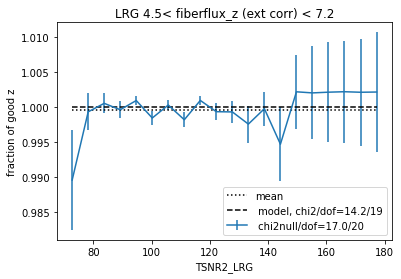

26012
25958
0.9979240350607412
19.482436934512005 0.01


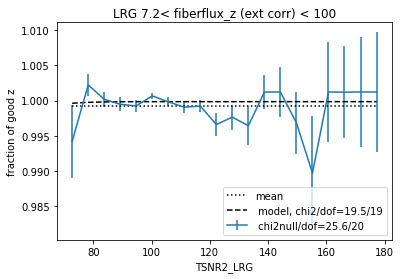

In [177]:
efac = 1#8.60
fs = [0,3,3.5,4.5,7.2]

#for fr,reg in zip(frl,regl):
#for c in nl:
cs = []
mfs = []
for i in range(0,len(fs)):
    wa = ff['LOCATION_ASSIGNED'] == 1
    wa &= ff['FIBERSTATUS'] == 0
    wa &= ff['TSNR2_LRG'] != 1e20
    fm = fs[i]
    
    if i == len(fs)-1:
        fx = 100
    else:
        fx = fs[i+1]
    wa &= (fibfluxz < fx)
    wa &= (fibfluxz > fm)
    #wa &= ff['PHOTSYS'] == reg
    wgh = wa & (ff['ZWARN'] == 0) & (ff['DELTACHI2'] > 16)
    print(len(ff[wa]))
    #wgh &= ff['Z'] > zmin
    #wgh &= ff['Z'] < zmax

    print(len(ff[wgh]))
    ffo = ff[wa]
    ffz = ff[wgh]
    print(len(ffz)/len(ffo))
    rng = (70,180)
    nb = 20
    bs = (rng[1]-rng[0])/nb
    a = np.histogram(ffz['TSNR2_LRG'],bins=nb,range=rng,weights=ffz['WEIGHT_ZFAIL'])
    c = np.histogram(ffz['TSNR2_LRG'],bins=nb,range=rng)
    b = np.histogram(ffo['TSNR2_LRG'],bins=a[1])
    #plt.clf()
    fr = np.sum(a[0])/np.sum(b[0])
    dl = a[0]/b[0]#/fr
    dlv = c[0]/b[0]#/fr
    varl = dlv*b[0]*(1.-dlv) #variance for binomial distribution
    wv = varl == 0
    varl[wv] = 1
    el = np.sqrt(varl)/b[0]#/fr
    #el = np.sqrt(b[0]-a[0])/b[0]
    #(nt*nnwt/nt*(1.-nnwt/nt))**.5/nt

    vs = a[1][:-1]+bs/2.
    ol = np.ones(len(vs))#*0.74
    #deg = 4
    #coeff = np.polyfit(vs,dl,deg,w=1/el)
    #em = erf((vs)/50)*.975
    #em = np.zeros(len(vs))
    #for i in range(0,deg+1):
    #    em += coeff[i]*vs**(deg-i)
    #em = coeff[0]*vs**4+coeff[1]*vs**3+coeff[2]*vs**2.+coeff[3]*vs +coeff[4]
    efi = 0
    chi2min = 1000
    wv = vs > 180
    while efi < 4:
        emfi = 1. -(1.-em)*efi
        emfi[wv] =1.
        chi2i = np.sum((dl-emfi)**2./el**2.)
        if chi2i < chi2min:
            chi2min = chi2i
            ef = efi
        efi += 0.01
    print(chi2min,ef)
    cs.append(ef)
    mfs.append(np.mean(fibfluxz[wa]))
    emf = 1. -(1.-em)*ef
    
    emf[wv] =1.
    chi2m = np.sum((dl-emf)**2./el**2.)
    chi2null = np.sum((dl-fr)**2./el**2.)
    
    plt.errorbar(a[1][:-1]*efac+bs/2.,dl,el,label=' chi2null/dof='+str(round(chi2null,1))+'/'+str(nb))#,fmt='ko')


    ol = np.ones(len(vs))*fr#*0.54
    plt.plot(vs*efac,ol,'k:',label='mean')
    plt.plot(vs*efac,emf,'k--',label=' model, chi2/dof='+str(round(chi2m,1))+'/'+str(nb-deg))             
    plt.title('LRG '+ str(fm)+'< fiberflux_z (ext corr) < '+str(fx))
    #if c == 0:
    #    plt.title('LRG fiberflux_z (ext corr) < '+str(fx))
    #else:
    #    plt.title('LRG fiberflux_z (ext corr) > '+str(fx))
    plt.xlabel('TSNR2_LRG')
    plt.ylabel('fraction of good z')
    plt.legend(loc='lower right')
    plt.show()  

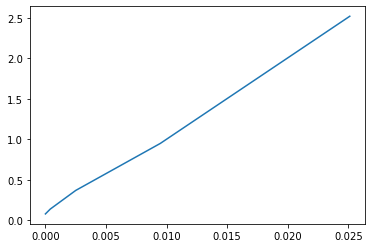

In [148]:
plt.plot(1./(np.array(mfs)**4.5),cs)

In [149]:
1./(np.array(mfs)**4.5)

array([2.5113057e-02, 9.4840713e-03, 2.5117556e-03, 4.1308702e-04,
       1.1094129e-05], dtype=float32)

In [131]:
cs

[2.5199999999999902,
 0.9500000000000006,
 0.37000000000000016,
 0.13999999999999999,
 0.08]

In [145]:
fcs = .08+2.42*(np.array(mfs))**-4/.038

In [144]:
np.array(mfs)**-.25

array([0.8149023, 0.7719885, 0.717058 , 0.6486379, 0.5305513],
      dtype=float32)

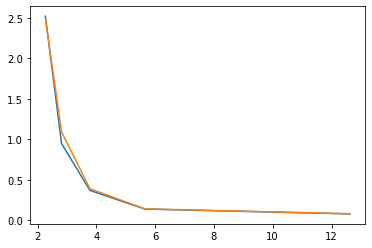

In [146]:
plt.plot(mfs,cs)
plt.plot(mfs,fcs)

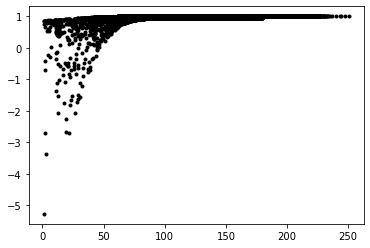

In [161]:
zw = np.ones(len(ff))
wv = ff['TSNR2_LRG'] < 180
efs = .08+2.42*(fibfluxz)**-4/.038
ems = erf((ff['TSNR2_LRG']-25)/30)*.986
zw[wv] = 1. -(1.-ems[wv])*efs[wv]
plt.plot(ff[wgh]['TSNR2_LRG'],zw[wgh],'k.')

45877
44805
0.9766331713058831


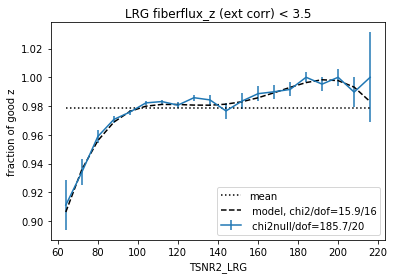

53044
52871
0.9967385566699344


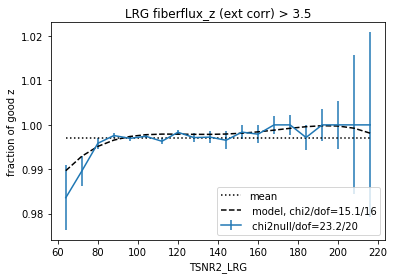

In [123]:
efac = 1#8.60
nl = [0,1]
#for fr,reg in zip(frl,regl):
for c in nl:
    wa = ff['LOCATION_ASSIGNED'] == 1
    wa &= ff['FIBERSTATUS'] == 0
    wa &= ff['TSNR2_LRG'] != 1e20
    fx = 3.5
    if c == 0:
        wa &= fibfluxz < fx
        ef = 2
    if c == 1:
        wa &= fibfluxz > fx
        ef = 0.22
    #wa &= ff['PHOTSYS'] == reg
    wgh = wa & (ff['ZWARN'] == 0)
    print(len(ff[wa]))
    #wgh &= ff['Z'] > zmin
    #wgh &= ff['Z'] < zmax

    print(len(ff[wgh]))
    ffo = ff[wa]
    ffz = ff[wgh]
    print(len(ffz)/len(ffo))
    rng = (60,220)
    nb = 20
    bs = (rng[1]-rng[0])/nb
    a = np.histogram(ffz['TSNR2_LRG'],bins=nb,range=rng)
    b = np.histogram(ffo['TSNR2_LRG'],bins=a[1])
    #plt.clf()
    fr = np.sum(a[0])/np.sum(b[0])
    dl = a[0]/b[0]#/fr
    varl = dl*b[0]*(1.-dl) #variance for binomial distribution
    wv = varl == 0
    varl[wv] = 1
    el = np.sqrt(varl)/b[0]#/fr
    #el = np.sqrt(b[0]-a[0])/b[0]
    #(nt*nnwt/nt*(1.-nnwt/nt))**.5/nt

    vs = a[1][:-1]+bs/2.
    ol = np.ones(len(vs))#*0.74
    #deg = 4
    #coeff = np.polyfit(vs,dl,deg,w=1/el)
    #em = erf((vs)/50)*.975
    #em = np.zeros(len(vs))
    #for i in range(0,deg+1):
    #    em += coeff[i]*vs**(deg-i)
    #em = coeff[0]*vs**4+coeff[1]*vs**3+coeff[2]*vs**2.+coeff[3]*vs +coeff[4]
    chi2null = np.sum((dl-fr)**2./el**2.)
    chi2m = np.sum((dl+em*ef-1)**2./el**2.)
    plt.errorbar(a[1][:-1]*efac+bs/2.,dl,el,label=' chi2null/dof='+str(round(chi2null,1))+'/'+str(nb))#,fmt='ko')


    ol = np.ones(len(vs))*fr#*0.54
    plt.plot(vs*efac,ol,'k:',label='mean')
    plt.plot(vs*efac,1-em*ef,'k--',label=' model, chi2/dof='+str(round(chi2m,1))+'/'+str(nb-deg))             
    if c == 0:
        plt.title('LRG fiberflux_z (ext corr) < '+str(fx))
    else:
        plt.title('LRG fiberflux_z (ext corr) > '+str(fx))
    plt.xlabel('TSNR2_LRG')
    plt.ylabel('fraction of good z')
    plt.legend(loc='lower right')
    plt.show()  

In [108]:
wa = ff['LOCATION_ASSIGNED'] == 1
wa &= ff['FIBERSTATUS'] == 0
wa &= ff['TSNR2_LRG'] != 1e20
wz = wa & (ff['TSNR2_LRG'] > 60)
print(len(ff[wz])/len(ff[wa]))

0.9898504867520547


39125
39035
0.9976996805111821


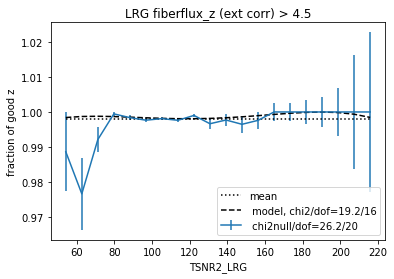

In [90]:
efac = 1#8.60
regl = ['N','S']
#for fr,reg in zip(frl,regl):
wa = ff['LOCATION_ASSIGNED'] == 1
wa &= ff['FIBERSTATUS'] == 0
wa &= ff['TSNR2_LRG'] != 1e20
wa &= fibfluxz > 4.5
#wa &= fibfluxz < 3.5
#wa &= ff['PHOTSYS'] == reg
wgh = wa & (ff['ZWARN'] == 0)
print(len(ff[wa]))
#wgh &= ff['Z'] > zmin
#wgh &= ff['Z'] < zmax

print(len(ff[wgh]))
ffo = ff[wa]
ffz = ff[wgh]
print(len(ffz)/len(ffo))
rng = (50,220)
nb = 20
bs = (rng[1]-rng[0])/nb
a = np.histogram(ffz['TSNR2_LRG'],bins=nb,range=rng)
b = np.histogram(ffo['TSNR2_LRG'],bins=a[1])
#plt.clf()
fr = np.sum(a[0])/np.sum(b[0])
dl = a[0]/b[0]#/fr
varl = dl*b[0]*(1.-dl) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
el = np.sqrt(varl)/b[0]#/fr
#el = np.sqrt(b[0]-a[0])/b[0]
#(nt*nnwt/nt*(1.-nnwt/nt))**.5/nt

vs = a[1][:-1]+bs/2.
ol = np.ones(len(vs))#*0.74
deg = 4
coeff = np.polyfit(vs,dl,deg,w=1/el)
#em = erf((vs)/50)*.975
em = np.zeros(len(vs))
for i in range(0,deg+1):
    em += coeff[i]*vs**(deg-i)
#em = coeff[0]*vs**4+coeff[1]*vs**3+coeff[2]*vs**2.+coeff[3]*vs +coeff[4]
chi2null = np.sum((dl-fr)**2./el**2.)
chi2m = np.sum((dl-em)**2./el**2.)
plt.errorbar(a[1][:-1]*efac+bs/2.,dl,el,label=' chi2null/dof='+str(round(chi2null,1))+'/'+str(nb))#,fmt='ko')


ol = np.ones(len(vs))*fr#*0.54
plt.plot(vs*efac,ol,'k:',label='mean')
plt.plot(vs*efac,em,'k--',label=' model, chi2/dof='+str(round(chi2m,1))+'/'+str(nb-deg))             
plt.title('LRG fiberflux_z (ext corr) > 4.5')
plt.xlabel('TSNR2_LRG')
plt.ylabel('fraction of good z')
plt.legend(loc='lower right')
plt.show()  

39290
38856
0.9889539322982948


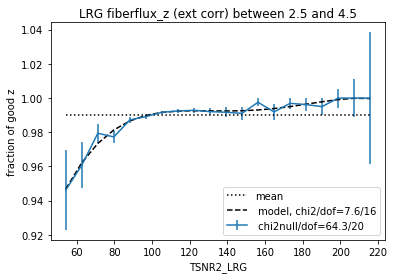

In [89]:
efac = 1#8.60
regl = ['N','S']
#for fr,reg in zip(frl,regl):
wa = ff['LOCATION_ASSIGNED'] == 1
wa &= ff['FIBERSTATUS'] == 0
wa &= ff['TSNR2_LRG'] != 1e20
wa &= fibfluxz > 2.5
wa &= fibfluxz < 4.5
#wa &= ff['PHOTSYS'] == reg
wgh = wa & (ff['ZWARN'] == 0)
print(len(ff[wa]))
#wgh &= ff['Z'] > zmin
#wgh &= ff['Z'] < zmax

print(len(ff[wgh]))
ffo = ff[wa]
ffz = ff[wgh]
print(len(ffz)/len(ffo))
rng = (50,220)
nb = 20
bs = (rng[1]-rng[0])/nb
a = np.histogram(ffz['TSNR2_LRG'],bins=nb,range=rng)
b = np.histogram(ffo['TSNR2_LRG'],bins=a[1])
#plt.clf()
fr = np.sum(a[0])/np.sum(b[0])
dl = a[0]/b[0]#/fr
varl = dl*b[0]*(1.-dl) #variance for binomial distribution
wv = varl == 0
varl[wv] = 1
el = np.sqrt(varl)/b[0]#/fr
#el = np.sqrt(b[0]-a[0])/b[0]
#(nt*nnwt/nt*(1.-nnwt/nt))**.5/nt

vs = a[1][:-1]+bs/2.
ol = np.ones(len(vs))#*0.74
deg = 4
coeff = np.polyfit(vs,dl,deg)
#em = erf((vs)/50)*.975
em = np.zeros(len(vs))
for i in range(0,deg+1):
    em += coeff[i]*vs**(deg-i)
#em = coeff[0]*vs**4+coeff[1]*vs**3+coeff[2]*vs**2.+coeff[3]*vs +coeff[4]
chi2null = np.sum((dl-fr)**2./el**2.)
chi2m = np.sum((dl-em)**2./el**2.)
plt.errorbar(a[1][:-1]*efac+bs/2.,dl,el,label=' chi2null/dof='+str(round(chi2null,1))+'/'+str(nb))#,fmt='ko')


ol = np.ones(len(vs))*fr#*0.54
plt.plot(vs*efac,ol,'k:',label='mean')
plt.plot(vs*efac,em,'k--',label=' model, chi2/dof='+str(round(chi2m,1))+'/'+str(nb-deg))             
plt.title('LRG fiberflux_z (ext corr) between 2.5 and 4.5')
plt.xlabel('TSNR2_LRG')
plt.ylabel('fraction of good z')
plt.legend(loc='lower right')
plt.show()  

20506
19785


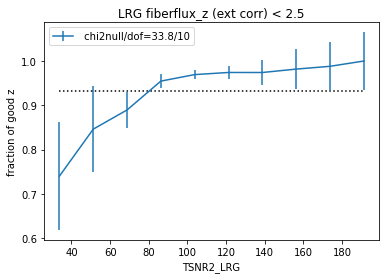

In [23]:
efac = 1#8.60
regl = ['N','S']
#for fr,reg in zip(frl,regl):
wa = ff['LOCATION_ASSIGNED'] == 1
wa &= ff['FIBERSTATUS'] == 0
wa &= ff['TSNR2_LRG'] != 1e20
wa &= fibfluxz < 2.5
#wa &= ff['PHOTSYS'] == reg
wgh = wa & (ff['ZWARN'] == 0)
print(len(ff[wa]))
#wgh &= ff['Z'] > zmin
#wgh &= ff['Z'] < zmax

print(len(ff[wgh]))
ffo = ff[wa]
ffz = ff[wgh]
rng = (25,200)
nb = 10
bs = (rng[1]-rng[0])/nb
a = np.histogram(ffz['TSNR2_LRG'],bins=nb,range=rng)
b = np.histogram(ffo['TSNR2_LRG'],bins=a[1])
#plt.clf()
fr = np.mean(a[0]/b[0])
dl = a[0]/b[0]#/fr
el = np.sqrt(a[0])/b[0]#/fr
vs = a[1][:-1]+bs/2.
ol = np.ones(len(vs))#*0.74
em = erf(vs/60)

chi2null = np.sum((dl-fr)**2./el**2.)
plt.errorbar(a[1][:-1]*efac+bs/2.,dl,el,label=' chi2null/dof='+str(round(chi2null,1))+'/'+str(nb))#,fmt='ko')


ol = np.ones(len(vs))*fr#*0.54
plt.plot(vs*efac,ol,'k:')
#plt.plot(vs*efac,em,'k--')             
plt.title('LRG fiberflux_z (ext corr) < 2.5')
plt.xlabel('TSNR2_LRG')
plt.ylabel('fraction of good z')
plt.legend(loc='upper left')
plt.show()  

53044
52871


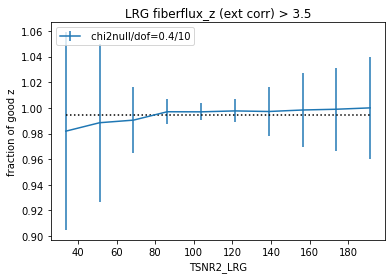

In [22]:
efac = 1#8.60
regl = ['N','S']
#for fr,reg in zip(frl,regl):
wa = ff['LOCATION_ASSIGNED'] == 1
wa &= ff['FIBERSTATUS'] == 0
wa &= ff['TSNR2_LRG'] != 1e20
wa &= fibfluxz > 3.5
#wa &= ff['PHOTSYS'] == reg
wgh = wa & (ff['ZWARN'] == 0)
print(len(ff[wa]))
#wgh &= ff['Z'] > zmin
#wgh &= ff['Z'] < zmax

print(len(ff[wgh]))
ffo = ff[wa]
ffz = ff[wgh]
rng = (25,200)
nb = 10
bs = (rng[1]-rng[0])/nb
a = np.histogram(ffz['TSNR2_LRG'],bins=nb,range=rng)
b = np.histogram(ffo['TSNR2_LRG'],bins=a[1])
#plt.clf()
fr = np.mean(a[0]/b[0])
dl = a[0]/b[0]#/fr
el = np.sqrt(a[0])/b[0]#/fr
vs = a[1][:-1]+bs/2.
ol = np.ones(len(vs))#*0.74
em = erf(vs/60)

chi2null = np.sum((dl-fr)**2./el**2.)
plt.errorbar(a[1][:-1]*efac+bs/2.,dl,el,label=' chi2null/dof='+str(round(chi2null,1))+'/'+str(nb))#,fmt='ko')


ol = np.ones(len(vs))*fr#*0.54
plt.plot(vs*efac,ol,'k:')
#plt.plot(vs*efac,em,'k--')             
plt.title('LRG fiberflux_z (ext corr) > 3.5')
plt.xlabel('TSNR2_LRG')
plt.ylabel('fraction of good z')
plt.legend(loc='upper left')
plt.show()  

98921
21269


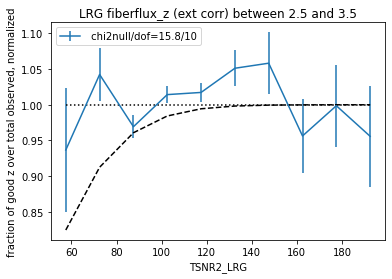

In [9]:
efac = 1#8.60
regl = ['N','S']
#for fr,reg in zip(frl,regl):
wa = ff['LOCATION_ASSIGNED'] == 1
wa &= ff['FIBERSTATUS'] == 0
wa &= ff['TSNR2_LRG'] != 1e20
#wa &= ff['PHOTSYS'] == reg
wgh = wa.copy()
wgh &= ff['ZWARN'] == 0
print(len(ff[wa]))
#wgh &= ff['Z'] > zmin
#wgh &= ff['Z'] < zmax
wgh &= fibfluxz > 2.5
wgh &= fibfluxz < 3.3
print(len(ff[wgh]))
ffo = ff[wa]
ffz = ff[wgh]
rng = (50,200)
nb = 10
bs = (rng[1]-rng[0])/nb
a = np.histogram(ffz['TSNR2_LRG'],bins=nb,range=rng)
b = np.histogram(ffo['TSNR2_LRG'],bins=a[1])
#plt.clf()
fr = np.mean(a[0]/b[0])
dl = a[0]/b[0]/fr
el = np.sqrt(a[0])/b[0]/fr
vs = a[1][:-1]+bs/2.
ol = np.ones(len(vs))#*0.74
em = erf(vs/60)

chi2null = np.sum((dl-1)**2./el**2.)
plt.errorbar(a[1][:-1]+bs/2,dl,el,label=' chi2null/dof='+str(round(chi2null,1))+'/'+str(nb))#,fmt='ko')


ol = np.ones(len(vs))#*0.54
plt.plot(vs*efac,ol,'k:')
plt.plot(vs*efac,em,'k--')             
plt.title('LRG fiberflux_z (ext corr) between 2.5 and 3.5')
plt.xlabel('TSNR2_LRG')
plt.ylabel('fraction of good z over total observed, normalized')
plt.legend(loc='upper left')
plt.show()  

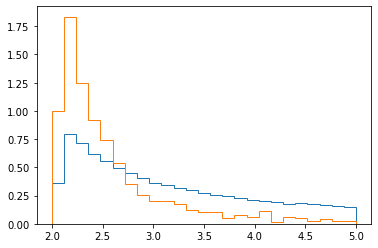

In [129]:
wa = ff['LOCATION_ASSIGNED'] == 1
wa &= ff['FIBERSTATUS'] == 0
wa &= ff['TSNR2_LRG'] != 1e20
wg = wa & (ff['ZWARN'] == 0)
wf = wa & (ff['ZWARN'] != 0)
plt.hist(fibfluxz[wg],bins=25,range=(2,5),density=True,histtype='step')
plt.hist(fibfluxz[wf],bins=25,range=(2,5),density=True,histtype='step')
plt.show()

In [127]:
np.unique(ff[wa]['ZWARN'])

array([   0,    4,   32,   36, 1024, 1056, 1060])

In [95]:
fc = fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/LSScats/test/LRGAlltiles_clustering.dat.fits')

In [78]:
fc.dtype.names

('TARGETID', 'RA', 'DEC', 'Z', 'TILES', 'rosette_number', 'NTILE', 'WEIGHT')

In [96]:
fcr = fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/LSScats/test/LRGAlltiles_0_clustering.ran.fits')

In [80]:
fcr.dtype.names

('TARGETID', 'RA', 'DEC', 'rosette_number', 'TILES', 'NTILE', 'Z', 'WEIGHT')

0.0 151.94056552203946
1.0 207.00794003057652
2.0 199.46677199565517
3.0 179.78035203851363
4.0 162.95399515738498
5.0 164.9615742327084
6.0 177.03916818090048
7.0 210.64195643867023
8.0 224.85600354452814
9.0 215.44775025648542
10.0 183.05313358061562
11.0 178.8560939085068
12.0 155.9828015830361
13.0 179.2897086235652
14.0 174.08193794334798
15.0 175.5590427618674


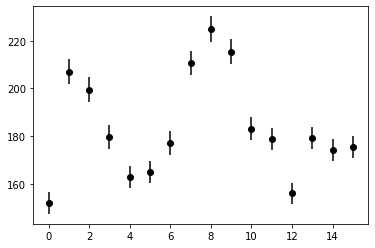

In [99]:
ros = np.unique(fc['rosette_number'])
zmin = 0.32
zmax = 0.6
rl = []
nl = []
el = []
for rs in ros:
    wd = fc['Z'] > zmin
    wd &= fc['Z'] < zmax
    wd &= fc['rosette_number'] == rs
    wr = fcr['rosette_number'] == rs
    #print(rs,np.sum(fc[wd]['WEIGHT'])/len(fcr[wr])*2500)
    rl.append(rs)
    ng = np.sum(fc[wd]['WEIGHT'])/len(fcr[wr])*2500
    nl.append(ng)
    el.append(ng*np.sqrt(len(fc[wd]['WEIGHT']))/len(fc[wd]['WEIGHT']))
plt.errorbar(rl,nl,el,fmt='ko')
plt.show()

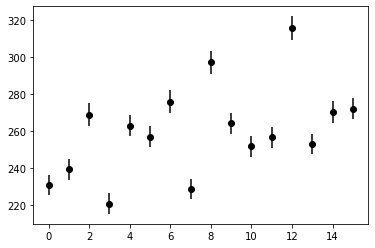

In [100]:
zmin = 0.6
zmax = 0.8
rl = []
nl = []
el = []
for rs in ros:
    wd = fc['Z'] > zmin
    wd &= fc['Z'] < zmax
    wd &= fc['rosette_number'] == rs
    wr = fcr['rosette_number'] == rs
    #print(rs,np.sum(fc[wd]['WEIGHT'])/len(fcr[wr])*2500)
    rl.append(rs)
    ng = np.sum(fc[wd]['WEIGHT'])/len(fcr[wr])*2500
    nl.append(ng)
    el.append(ng*np.sqrt(len(fc[wd]['WEIGHT']))/len(fc[wd]['WEIGHT']))
plt.errorbar(rl,nl,el,fmt='ko')
plt.show()

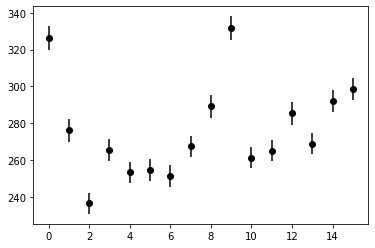

In [101]:
zmin = 0.8
zmax = 1.05
rl = []
nl = []
el = []
for rs in ros:
    wd = fc['Z'] > zmin
    wd &= fc['Z'] < zmax
    wd &= fc['rosette_number'] == rs
    wr = fcr['rosette_number'] == rs
    #print(rs,np.sum(fc[wd]['WEIGHT'])/len(fcr[wr])*2500)
    rl.append(rs)
    ng = np.sum(fc[wd]['WEIGHT'])/len(fcr[wr])*2500
    nl.append(ng)
    el.append(ng*np.sqrt(len(fc[wd]['WEIGHT']))/len(fc[wd]['WEIGHT']))
plt.errorbar(rl,nl,el,fmt='ko')
plt.show()

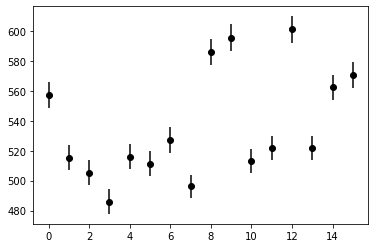

In [104]:
ros = np.unique(fc['rosette_number'])
zmin = 0.6
zmax = 1.05
rl = []
nl = []
el = []
ntm = 0
for rs in ros:
    wd = fc['Z'] > zmin
    wd &= fc['Z'] < zmax
    wd &= fc['rosette_number'] == rs
    wd &= fc['NTILE'] > ntm
    wr = fcr['rosette_number'] == rs
    wr &= fcr['NTILE'] > ntm
    #print(rs,np.sum(fc[wd]['WEIGHT'])/len(fcr[wr])*2500)
    rl.append(rs)
    ng = np.sum(fc[wd]['WEIGHT'])/len(fcr[wr])*2500
    nl.append(ng)
    el.append(ng*np.sqrt(len(fc[wd]['WEIGHT']))/len(fc[wd]['WEIGHT']))
plt.errorbar(rl,nl,el,fmt='ko')
plt.show()

In [94]:
432//27

16

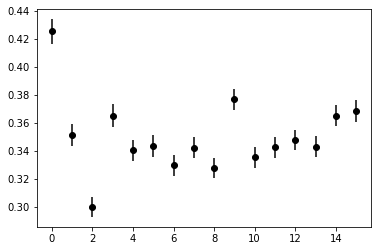

In [112]:
ros = np.unique(fc['rosette_number'])
zmin = 0.8
zmax = 1.05
rl = []
nl = []
el = []
for rs in ros:
    wdr = fc['rosette_number'] == rs
    wd = fc['Z'] > zmin
    wd &= fc['Z'] < zmax
    wd &= wdr
    wr = fcr['rosette_number'] == rs
    #print(rs,np.sum(fc[wd]['WEIGHT'])/len(fcr[wr])*2500)
    rl.append(rs)
    ng = np.sum(fc[wd]['WEIGHT'])/np.sum(fc[wdr]['WEIGHT'])#/len(fcr[wr])*2500
    nl.append(ng)
    el.append(ng*np.sqrt(len(fc[wd]['WEIGHT']))/len(fc[wd]['WEIGHT']))
plt.errorbar(rl,nl,el,fmt='ko')
plt.show()

In [123]:
import sys
sys.path.append('../py')

In [124]:
len(ff)

136657

In [126]:
from LSS.SV3 import cattools as ct

In [127]:
np.unique(ff['rosette_number'])

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19.])

In [134]:
rs = []
for i in range(0,len(ff)):
    rsi = ct.calc_rosr(ff[i]['rosette_number'],ff[i]['RA'],ff[i]['DEC'])
    rs.append(rsi)

In [129]:
import importlib

In [133]:
importlib.reload(ct)

<module 'LSS.SV3.cattools' from '../py/LSS/SV3/cattools.py'>

(array([ 1667.,  5099.,  8407., 11795., 15042., 18433., 21416., 24435.,
        24163.,  6200.]),
 array([0.00494737, 0.1904133 , 0.37587923, 0.56134516, 0.74681109,
        0.93227702, 1.11774294, 1.30320887, 1.4886748 , 1.67414073,
        1.85960666]),
 <a list of 10 Patch objects>)

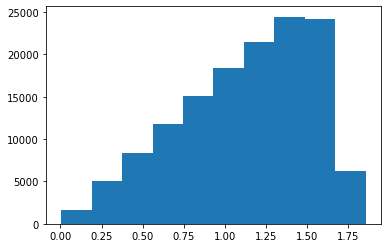

In [136]:
plt.hist(rs)

In [137]:
max(rs)

1.8596066592713076